In [1]:
#imports 
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as sm
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import networkx as nx
from sklearn.preprocessing import StandardScaler

# Create Dataset

### Define useful functions


In [2]:
#we mimic 4-class system from World Bank -- 4 growth categoris: 0 - L, 1 - LM, 2 - UM, 3 - U
def growth_categories(x, growth_list):
    threshold_high = np.percentile(growth_list, 75)
    threshold_low = np.percentile(growth_list, 25)
    threshold_mid = np.percentile(growth_list, 50)
    
    if(x > threshold_high): return 3
    elif(x < threshold_low): return 0
    elif(x < threshold_mid): return 1
    else: return 2

### Use class to:
- import and combine economic features 
- create graph features 
- find categories for GDP prediction

In [9]:
class CreateFeatures:
    """
    We define a class which builds the feature dataframe 
    """
    
    def __init__(self, year = 1962, data_dir = "../data/"):
        self.year = year
        self.data_dir = data_dir
        
    def prepare_econ_features(self, filter_gdp = True):
        
        #DATA IMPORT
        #import dictionary with all features from WB
        with open(self.data_dir + 'all_wb_indicators.pickle', 'rb') as handle:
            features_dict = pkl.load(handle)
            
        #import list of all features we want to select for
        with open(self.data_dir + 'candidate_features.pickle', 'rb') as handle:
            self.feature_list = pkl.load(handle)
        #look up each of the features -- add country feature in that year 
        i = 0
        for feature in self.feature_list:
            #find dataframe corresponding to specific feature name
            df = features_dict[feature]
            
            if (i == 0):
                self.features = df[["economy", "YR" + str(self.year)]]
            else: 
                self.features = pd.merge(self.features, 
                                            df[["economy", "YR" + str(self.year)]],
                                            on = "economy", how = "outer")
            self.features.rename(columns = {"YR" + str(self.year): feature}, inplace = True)
            i = i+1
        
        #prepare GDP feature
        self.gdp_growth = features_dict['NY.GDP.MKTP.KD.ZG']
        cols = list(self.gdp_growth.columns.copy())
        cols.remove("economy")
        self.gdp_growth["country_sd"] = self.gdp_growth[cols].std(axis=1)
        #select potential variables 
        self.gdp_growth["prev_gdp_growth"] = self.gdp_growth["YR" + str(self.year-1)]
        self.gdp_growth["current_gdp_growth"] = self.gdp_growth["YR" + str(self.year)] 
        self.gdp_growth["future_3y_gdp_growth"] = self.gdp_growth["YR" + str(self.year+1)]\
        +self.gdp_growth["YR" + str(self.year+2)]+self.gdp_growth["YR" + str(self.year+3)] 
        #we eliminate countries that are too volatile in growth -- probably an indicator that growth estimates are inaccurate
        self.high_vol_countries = list(set(self.gdp_growth[self.gdp_growth["country_sd"] > 10]["economy"]))
        self.gdp_growth = self.gdp_growth[["economy", "prev_gdp_growth",
                                "current_gdp_growth", "future_3y_gdp_growth"]].dropna()
        
        #combine GDP and other features
        self.features = pd.merge(self.gdp_growth, self.features,
                                   on = "economy", how = "left")
        #we only keep countries where we observe GDP growth -- otherwise nothing to predict
        #we keep countries where other features may be missing -- and fill NAs with 0 
        self.features.rename(columns = {"economy": "country_code"}, inplace = True)
        
    def prepare_network_features(self):
        """
        We create an initial, import-centric trade link pandas dataframe for a given year
        """
        #get product codes
        data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')
        data_cross = []
        i = 0
        for item_def in list(data_dict["results"]):
            if(i >= 2):
                data_cross.append(item_def["text"].split(" - ", 1))
            i = i+1

        self.product_codes = pd.DataFrame(data_cross, columns = ['code', 'product'])
        self.product_codes["sitc_product_code"] = self.product_codes["code"]
        
        #get country codes
        self.country_codes = pd.read_excel(self.data_dir + "ISO3166.xlsx")
        self.country_codes["location_code"] = self.country_codes["Alpha-3 code"]
        self.country_codes["partner_code"] = self.country_codes["Alpha-3 code"]
        self.country_codes["country_i"] = self.country_codes["English short name"]
        self.country_codes["country_j"] = self.country_codes["English short name"]
        
        #get trade data for a given year
        trade_data = pd.read_stata(self.data_dir + "country_partner_sitcproduct4digit_year_"+ str(self.year)+".dta") 
        #merge with product / country descriptions
        trade_data = pd.merge(trade_data, self.country_codes[["location_code", "country_i"]],on = ["location_code"])
        trade_data = pd.merge(trade_data, self.country_codes[["partner_code", "country_j"]],on = ["partner_code"])
        trade_data = pd.merge(trade_data, self.product_codes[["sitc_product_code", "product"]], 
                              on = ["sitc_product_code"])
        ###select level of product aggregation
        trade_data["product_category"] = trade_data["sitc_product_code"].apply(lambda x: x[0:1])
        #trade_data = trade_data[trade_data["product_category"] == "1"]
        
        #keep only nodes that we have features for
        trade_data = trade_data[trade_data["location_code"].isin(self.features["country_code"])]
        trade_data = trade_data[trade_data["partner_code"].isin(self.features["country_code"])]
        
        if (len(trade_data.groupby(["location_code", "partner_code", "sitc_product_code"])["import_value"].sum().reset_index()) != len(trade_data)):
            print("import, export, product combination not unique!")
        self.trade_data1 = trade_data
        #from import-export table, create only import table
        #extract imports
        imports1 = trade_data[['location_id', 'partner_id', 'product_id', 'year',
               'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code', 'country_i', 'country_j', 'product', "product_category"]]
        imports1 = imports1[imports1["import_value"] != 0]
        #transform records of exports into imports
        imports2 = trade_data[['location_id', 'partner_id', 'product_id', 'year',
               'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code', 'country_i', 'country_j', 'product', "product_category"]]
        imports2["temp1"] = imports2['partner_code']
        imports2["temp2"] = imports2['location_code']

        imports2['location_code'] = imports2["temp1"]
        imports2['partner_code'] = imports2["temp2"]
        imports2["import_value"] = imports2["export_value"]
        imports2 = imports2[imports2["import_value"] != 0]
        imports2 = imports2[['location_id', 'partner_id', 'product_id', 'year',
               'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code', 'country_i', 'country_j', 'product', "product_category"]]
        
        imports_table = imports1.append(imports2).drop_duplicates()
        
        #rename columns for better clarity
        imports_table["importer_code"] = imports_table["location_code"]
        imports_table["exporter_code"] = imports_table["partner_code"]
        imports_table["importer_name"] = imports_table["country_i"]
        imports_table["exporter_name"] = imports_table["country_j"]
        
        cols = ["importer_code", "exporter_code", "importer_name", "exporter_name",
               'product_id', 'year', 'import_value', 'sitc_eci', 'sitc_coi',
               'sitc_product_code', 'product', "product_category"]
        imports_table = imports_table[cols]
        
        exporter_total = imports_table.groupby(["exporter_code"])["import_value"].sum().reset_index()
        exporter_total = exporter_total.rename(columns = {"import_value": "export_total"})
        
        importer_total = imports_table.groupby(["importer_code"])["import_value"].sum().reset_index()
        importer_total = importer_total.rename(columns = {"import_value": "import_total"})
        
        ##### COMPUTE CENTRALITY FOR COUNTRY
        #sum imports across all products between countries into single value 
        imports_table_grouped = imports_table.groupby(["importer_code", "exporter_code"])["import_value"].sum().reset_index()
        imports_table_grouped = pd.merge(imports_table_grouped, importer_total, on = "importer_code")
        imports_table_grouped["import_fraction"] = imports_table_grouped["import_value"]\
                        /imports_table_grouped["import_total"]*100
        
        self.trade_data = imports_table_grouped
        
        #filter features and nodes to ones that are connected to others in trade data
        list_active_countries = list(set(list(self.trade_data ["importer_code"])+\
                        list(self.trade_data ["exporter_code"])))
        self.features = self.features[self.features["country_code"].isin(list_active_countries)].reset_index()
        self.features["node_numbers"] = self.features.index
        
        G=nx.from_pandas_edgelist(self.trade_data, 
                          "exporter_code", "importer_code", create_using = nx.DiGraph())
        self.G = G
        self.centrality_overall= nx.eigenvector_centrality(G, max_iter= 10000) 
        self.centrality_overall = pd.DataFrame(list(map(list, self.centrality_overall.items())), 
                                               columns = ["country_code", "centrality_overall"])
        G=nx.from_pandas_edgelist(self.trade_data, 
                          "exporter_code", "importer_code", ["import_fraction"])
        weighted_centrality = nx.eigenvector_centrality(G, weight = "import_fraction", max_iter= 10000) 
        weighted_centrality  = pd.DataFrame(list(map(list, weighted_centrality.items())), 
                                               columns = ["country_code", "weighted_centrality"])
        self.centrality_overall = pd.merge(self.centrality_overall, weighted_centrality, on = "country_code")
        
                               
        ##### COMPUTE CENTRALITY FOR COUNTRY IN PRODUCT CATEGORIES

        #sum imports across all products between countries into single value 
        imports_table_grouped = imports_table.groupby(["importer_code", "exporter_code"])["import_value"].sum().reset_index()
        products_grouped = imports_table.groupby(["product_category"])["import_value"].sum().reset_index()
        products_grouped = products_grouped.rename(columns = {"import_value": "import_product_total"})
        
        #sum exports in each category 
        self.export_types = imports_table.groupby(["importer_code", "exporter_code", "product_category"])["import_value"].sum().reset_index()
        self.export_types = pd.merge(products_grouped, self.export_types, on = "product_category")
        
        self.export_types["product_export_fraction"] = self.export_types["import_value"]\
                                                    /self.export_types["import_product_total"]*100
        
        list_products = list(set(self.export_types["product_category"]))
        
        i = 0 
        for product in list_products:
            
            temp = self.export_types[self.export_types["product_category"] == product].copy()
            
            G_w=nx.from_pandas_edgelist(temp, 
                "exporter_code", "importer_code", ["product_export_fraction"], create_using = nx.DiGraph())
            centrality_product_w = nx.eigenvector_centrality(G_w, weight = "product_export_fraction", 
                                                           max_iter= 10000)

            G=nx.from_pandas_edgelist(temp,"exporter_code", "importer_code", create_using = nx.DiGraph())
            centrality_product = nx.eigenvector_centrality(G,max_iter= 10000)

            if(i == 0):
                self.centrality_product = pd.DataFrame(list(map(list, centrality_product.items())), 
                                               columns = ["country_code", "prod_" + product])
                

            else: 
                self.centrality_product = pd.merge(self.centrality_product, 
                                               pd.DataFrame(list(map(list, centrality_product.items())), 
                                               columns = ["country_code", "prod_" + product]), 
                                                  on = "country_code")
                
            self.centrality_product = pd.merge(self.centrality_product, 
                                               pd.DataFrame(list(map(list, centrality_product_w.items())), 
                                               columns = ["country_code", "prod_w_" + product]), 
                                                  on = "country_code")
            
            i = i+1         
    
    def combine_normalize_features(self):
        
        self.combined_features = pd.merge(self.features, self.centrality_overall,on = "country_code")
        self.combined_features = pd.merge(self.combined_features, self.centrality_product,on = "country_code")
        #step eliminates NA and nodes that are not in graph, since they will have NA for graph features
        self.combined_features = self.combined_features.drop(columns = ["index"])
        #filter to non-volatile countries
        self.combined_features = self.combined_features[\
                                ~self.combined_features.country_code.isin(self.high_vol_countries)]
        #filter both trade data and features data to same subset of countries
        self.combined_features = self.combined_features[\
                                self.combined_features.country_code.isin(self.trade_data.importer_code)|\
                                self.combined_features.country_code.isin(self.trade_data.exporter_code)]
        self.trade_data = self.trade_data[\
                          self.trade_data.importer_code.isin(self.combined_features.country_code)&\
                          self.trade_data.exporter_code.isin(self.combined_features.country_code)]
        
        #extract categorical features and dependent variable for growth
        self.current_growth_list = list(self.combined_features["current_gdp_growth"])
        self.future_growth_list = list(self.combined_features["future_3y_gdp_growth"])
        self.combined_features["current_growth_cat"] = self.combined_features["current_gdp_growth"].\
                                                        apply(lambda x: growth_categories(x, self.current_growth_list))
        self.combined_features["future_growth_cat"] = self.combined_features["future_3y_gdp_growth"].\
                                                        apply(lambda x: growth_categories(x, self.future_growth_list))
        
        features_to_norm = list(self.combined_features.columns.copy())
        non_norm = ["country_code",'current_growth_cat','future_growth_cat', "node_numbers"]
        cols_insufficient_data = list(self.combined_features.loc[:, self.combined_features.nunique() < 2].columns.copy())
        non_norm.extend(cols_insufficient_data)
 
        features_to_norm = [x for x in features_to_norm if x not in non_norm]
        scaler = StandardScaler()
        #we preserve NAs in the scaling
        self.combined_features[features_to_norm] = scaler.fit_transform(self.combined_features[features_to_norm])
        self.combined_features.fillna(0, inplace = True) #we fill NA after scaling 
        #check that feature has at least 20% coverage in a given year -- otherwise set to NA
        for feature in self.feature_list:
            coverage = len(self.combined_features[self.combined_features[feature] != 0])/len(self.combined_features)
            if(coverage <= 0.20): self.combined_features[feature] = 0

In [10]:
%%time
trade_1970 = CreateFeatures(year = 1970)
trade_1970.prepare_econ_features()
trade_1970.prepare_network_features()
trade_1970.combine_normalize_features()

FileNotFoundError: [Errno 2] No such file or directory: '../data/candidate_features.pickle'

In [7]:
%%time

data_dict = {}

#GDP data goes up to 2018 -- trange up to 2019 spans up to 2018
for year in trange(1962, 2019):
    trade = CreateFeatures(year = year)
    trade.prepare_econ_features()
    trade.prepare_network_features()
    trade.combine_normalize_features()
    
    data_dict[year] = trade

  0%|                                                    | 0/57 [00:00<?, ?it/s]/home/semenova/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
  2%|▊                                           | 1/57 [00:11<11:11, 11.99s/it]/home/semenova/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
  4%|█▌                                          | 2/57 [00:25<12:01, 13.12s/it]/home/semenova/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingW

 35%|███████████████                            | 20/57 [06:06<11:55, 19.33s/it]/home/semenova/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
 37%|███████████████▊                           | 21/57 [06:27<11:59, 19.97s/it]/home/semenova/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
 39%|████████████████▌                          | 22/57 [06:49<11:53, 20.37s/it]/home/semenova/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingW

KeyboardInterrupt: 

In [8]:
#with open('trade_data.pickle', 'wb') as handle:
#    pkl.dump(data_dict, handle)

In [4]:
with open('all_wb_indicators.pickle', 'rb') as handle:
    coverage = pkl.load(handle)

In [5]:
with open('trade_data.pickle', 'rb') as handle:
    data_dict = pkl.load(handle)


In [6]:
combined_df = data_dict[1962].combined_features

for year in range(1963, 1993):
    combined_df = combined_df.append(data_dict[year].combined_features)

In [12]:
data_dict[1990].combined_features

,country_code,prev_gdp_growth,current_gdp_growth,future_3y_gdp_growth,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,AG.LND.CROP.ZS,AG.LND.FRST.ZS,BG.GSR.NFSV.GD.ZS,BM.KLT.DINV.WD.GD.ZS,...,prod_0,prod_w_0,prod_1,prod_w_1,prod_4,prod_w_4,prod_5,prod_w_5,current_growth_cat,future_growth_cat
0,ABW,2.018657,0.249688,1.124794,-1.145006,-0.179180,0.000000,-1.394662,2.913478,10.416122,...,-1.264016,-0.299666,-0.966323,-0.287862,-1.014212,-0.408740,-1.476321,-0.384619,2,3
1,AGO,-0.802179,-1.316543,-2.886683,0.016638,-0.831848,-0.564039,1.112271,-0.151628,-0.154565,...,-0.381776,-0.245876,-0.355159,-0.270368,-0.105313,-0.160218,-0.706428,-0.371214,0,0
2,ALB,1.483508,-2.611019,-2.629823,0.222729,0.565265,0.078991,-0.311779,-0.945804,-0.155896,...,-1.195228,-0.297240,-0.976695,-0.340715,-1.063951,-0.341309,-1.362515,-0.383995,0,0
3,AND,0.314517,0.211646,-0.376738,0.590981,-0.846594,0.000000,-0.096708,0.000000,0.000000,...,-1.253002,-0.259216,-0.703896,-0.236587,-1.176431,-0.373546,-1.514192,-0.365246,2,1
4,ARE,2.067207,3.285697,-0.134164,-1.470777,-0.968053,-0.582499,-1.348965,0.000000,-0.174778,...,0.419990,-0.146513,0.756944,0.245305,0.277579,-0.309827,0.391740,-0.272783,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,VUT,-0.454418,1.884133,-0.053725,-1.082675,-0.882773,0.603695,-0.004965,1.693241,-0.155896,...,-1.318196,-0.305994,-0.919589,-0.345156,-1.370308,-0.411900,-1.270306,-0.387812,3,1
139,WSM,0.053226,-1.521813,-0.444454,-0.779214,-0.505874,1.176017,1.057366,1.597646,-0.155896,...,-1.179931,-0.305469,-1.183240,-0.346462,-1.106608,-0.412524,-1.384747,-0.387988,0,0
140,ZAF,-0.253056,-0.654604,-0.727094,1.961909,-0.220750,-0.587801,-0.878008,-0.789515,-0.152210,...,0.084935,-0.245509,0.135204,-0.133190,0.374765,-0.140978,0.218741,0.020080,0,0
141,ZMB,-1.050730,-0.689115,-0.169156,-0.370130,-0.715742,-0.621861,1.120458,-0.267754,-0.155896,...,-0.990049,-0.305011,-0.631172,-0.340402,-0.601824,-0.387612,-0.696380,-0.376505,0,1


In [7]:
combined_df.loc[:, combined_df.nunique() < 400].columns

Index(['country_code', 'EG.ELC.ACCS.ZS', 'EG.FEC.RNEW.ZS', 'MS.MIL.TOTL.TF.ZS',
       'SL.UEM.TOTL.ZS', 'current_growth_cat', 'future_growth_cat'],
      dtype='object')

In [8]:
non_features = ['EG.ELC.ACCS.ZS', 'EG.FEC.RNEW.ZS', 'MS.MIL.TOTL.TF.ZS',
       'SL.UEM.TOTL.ZS', "country_code"]
feat_columns = [col for col in list(combined_df.columns) if col not in non_features]

In [9]:
combined_df

,country_code,prev_gdp_growth,current_gdp_growth,future_3y_gdp_growth,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,AG.LND.CROP.ZS,AG.LND.FRST.ZS,BG.GSR.NFSV.GD.ZS,BM.KLT.DINV.WD.GD.ZS,...,prod_0,prod_w_0,prod_1,prod_w_1,prod_4,prod_w_4,prod_5,prod_w_5,current_growth_cat,future_growth_cat
0,ARG,0.211701,-1.171612,-0.109547,0.667783,-0.430974,-0.569604,0.000000,0.000000,0.000000,...,0.108547,-0.417220,0.573368,-0.077722,0.369508,-0.474476,0.896863,-0.060097,0,1
1,AUS,-0.273963,-0.734018,0.262120,1.204795,-0.803518,-0.672839,0.000000,0.000000,0.000000,...,0.485753,-0.261543,0.427200,1.280077,0.887385,0.326040,0.304544,1.252456,0,2
2,AUT,0.229862,-0.457991,-0.271441,0.356437,0.566879,-0.408625,0.000000,0.000000,0.000000,...,0.111278,-0.226484,-0.189585,-0.100163,0.220959,-0.177256,-0.069948,-0.364100,0,1
3,BEL,0.137591,0.064546,-0.160863,0.909244,1.330094,-0.301756,0.000000,0.000000,0.000000,...,2.124030,1.102394,2.553321,0.949446,1.904385,0.043449,1.399081,1.296664,2,1
4,BEN,-0.165356,-1.696403,0.016446,-0.958049,-0.331817,-0.435658,0.000000,0.000000,0.000000,...,-0.915706,-0.484790,-0.676414,-0.396336,-1.178114,-0.494097,-1.108874,-0.656627,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,WSM,-0.783576,-0.353063,-0.055471,-0.860214,-0.575327,1.014358,1.062708,2.230991,-0.321454,...,-1.274421,-0.301501,-1.351775,-0.355241,-1.337053,-0.396140,-1.484602,-0.391847,1,1
151,YEM,0.808303,1.062926,0.621751,0.329106,-0.818676,-0.565459,-1.432937,0.000000,0.000000,...,-0.034140,-0.245753,-0.574791,-0.301570,-0.428353,-0.346694,0.039245,-0.372086,3,3
152,ZAF,-0.546139,-0.679297,-0.113386,1.926400,-0.228347,-0.557129,-0.864742,-0.874945,0.833833,...,1.130918,-0.205207,0.792692,-0.201518,1.471180,-0.204815,1.186373,0.026593,0,1
153,ZMB,-0.364210,-0.610901,-0.649741,-0.406266,-0.737852,-0.588447,1.135936,0.000000,0.000000,...,-0.782238,-0.290462,-0.800780,-0.353067,-0.657383,-0.370541,-0.508357,-0.380890,0,0


In [20]:
# calculate correlation matrix
corr_matrix = combined_df[feat_columns].corr()

# set correlation threshold
threshold = 0.4

# select pairs of columns that have a correlation higher than the threshold
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            high_corr_pairs.append((colname1, colname2))

In [21]:
high_corr_pairs

[('AG.LND.ARBL.ZS', 'AG.LND.AGRI.ZS'),
 ('SE.PRM.NENR', 'SE.PRM.CMPT.ZS'),
 ('SH.DYN.MORT', 'FD.AST.PRVT.GD.ZS'),
 ('SH.DYN.MORT', 'SE.PRM.CMPT.ZS'),
 ('SH.DYN.MORT', 'SE.PRM.NENR'),
 ('SP.POP.GROW', 'SH.DYN.MORT'),
 ('SP.URB.GROW', 'SH.DYN.MORT'),
 ('SP.URB.GROW', 'SP.POP.GROW'),
 ('SP.RUR.TOTL.ZG', 'SP.POP.GROW'),
 ('centrality_overall', 'FD.AST.PRVT.GD.ZS'),
 ('centrality_overall', 'SH.DYN.MORT'),
 ('centrality_overall', 'SP.URB.GROW'),
 ('weighted_centrality', 'centrality_overall'),
 ('prod_9', 'FD.AST.PRVT.GD.ZS'),
 ('prod_9', 'SH.DYN.MORT'),
 ('prod_9', 'SP.URB.GROW'),
 ('prod_9', 'centrality_overall'),
 ('prod_9', 'weighted_centrality'),
 ('prod_w_9', 'centrality_overall'),
 ('prod_w_9', 'weighted_centrality'),
 ('prod_w_9', 'prod_9'),
 ('prod_6', 'FD.AST.PRVT.GD.ZS'),
 ('prod_6', 'SH.DYN.MORT'),
 ('prod_6', 'SP.URB.GROW'),
 ('prod_6', 'centrality_overall'),
 ('prod_6', 'weighted_centrality'),
 ('prod_6', 'prod_9'),
 ('prod_6', 'prod_w_9'),
 ('prod_w_6', 'centrality_overall'),
 

In [10]:
import statsmodels.api as sm

X = combined_df[feat_columns].drop(['future_growth_cat', 'future_3y_gdp_growth'], axis=1)
X = sm.add_constant(X)
Y = combined_df['future_3y_gdp_growth']

model = sm.OLS(Y, X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.190
Model:                              OLS   Adj. R-squared:                  0.177
Method:                   Least Squares   F-statistic:                     14.95
Date:                  Fri, 18 Aug 2023   Prob (F-statistic):          5.73e-115
Time:                          15:24:48   Log-Likelihood:                -4421.5
No. Observations:                  3366   AIC:                             8949.
Df Residuals:                      3313   BIC:                             9273.
Df Model:                            52                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

In [24]:
print(model)

LinearRegression()


In [7]:
%%time
trade_1970 = TradeNetwork2(year = 1970)
trade_1970.prepare_features()
trade_1970.prepare_network()

CPU times: user 29.5 s, sys: 2.98 s, total: 32.5 s
Wall time: 33.1 s


In [151]:
trade_1970.centrality_overall

,country_code,centrality_overall,in_centrality,out_centrality,weighted_centrality
0,AUS,0.141301,0.622449,0.653061,0.090514
1,ARG,0.124016,0.510204,0.581633,0.021819
2,AUT,0.155910,0.724490,0.785714,0.020322
3,BEL,0.177671,0.897959,0.928571,0.143990
4,BHS,0.040341,0.142857,0.122449,0.000477
...,...,...,...,...,...
94,BLZ,0.020415,0.061224,0.030612,0.004853
95,SLE,0.073913,0.265306,0.112245,0.095898
96,GMB,0.055578,0.204082,0.051020,0.094691
97,SYC,0.018908,0.061224,0.020408,0.112535


In [152]:
trade_1970.centrality_product

,country_code,prod_7,prod_w_7,in_centrality_7,out_centrality_7,prod_3,prod_w_3,in_centrality_3,out_centrality_3,prod_4,...,in_centrality_6,out_centrality_6,prod_1,prod_w_1,in_centrality_1,out_centrality_1,prod_0,prod_w_0,in_centrality_0,out_centrality_0
0,AUS,0.114928,2.070405e-01,0.357143,0.653061,0.162872,0.016852,0.285714,0.316327,1.606546e-01,...,0.500000,0.622449,0.173426,0.091721,0.367347,0.336735,0.142778,0.023963,0.530612,0.632653
1,ARG,0.120239,6.820504e-02,0.367347,0.520408,0.171167,0.020796,0.285714,0.112245,1.106468e-01,...,0.408163,0.469388,0.112976,0.016740,0.214286,0.275510,0.105737,0.006093,0.346939,0.561224
2,AUT,0.104494,4.140119e-02,0.306122,0.785714,0.136044,0.021858,0.234694,0.132653,1.171978e-01,...,0.479592,0.785714,0.142397,0.022804,0.295918,0.224490,0.162125,0.031771,0.642857,0.540816
3,BEL,0.189868,2.485420e-01,0.704082,0.928571,0.172369,0.344011,0.336735,0.653061,1.916563e-01,...,0.775510,0.928571,0.206794,0.162322,0.510204,0.438776,0.194717,0.379736,0.857143,0.918367
4,BOL,0.095767,7.139216e-03,0.275510,0.061224,0.077704,0.000835,0.112245,0.030612,9.519825e-02,...,0.275510,0.132653,0.061281,0.002725,0.102041,0.000000,0.080203,0.003383,0.244898,0.132653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,SLE,0.074113,2.649019e-03,0.193878,0.030612,0.075249,0.000347,0.112245,0.000000,6.817942e-02,...,0.234694,0.071429,0.062434,0.003476,0.102041,0.030612,0.070261,0.004461,0.204082,0.071429
95,GMB,0.054577,2.797868e-04,0.132653,0.010204,0.031157,0.000035,0.040816,0.000000,1.684878e-02,...,0.153061,0.010204,0.047971,0.001912,0.071429,0.000000,0.053920,0.000358,0.163265,0.020408
96,SUR,0.067654,4.051891e-03,0.173469,0.040816,0.031034,0.002127,0.051020,0.000000,4.614309e-02,...,0.173469,0.102041,0.049438,0.007022,0.071429,0.020408,0.049635,0.004116,0.132653,0.102041
97,SYC,0.021434,2.414572e-04,0.051020,0.010204,0.009470,0.000003,0.010204,0.000000,2.030591e-02,...,0.061224,0.000000,0.023419,0.000792,0.030612,0.000000,0.017841,0.000114,0.051020,0.020408


In [157]:
trade_1970.features.columns

Index(['index', 'country_code', 'prev_gdp_growth', 'current_gdp_growth',
       'current_gdp_growth_log', 'future_gdp_growth', 'future_5y_gdp_growth',
       'future_3y_gdp_growth', 'future_5y_gdp_growth_log',
       'future_3y_gdp_growth_log', 'future_5y_gdp_sd', 'country_sd',
       'prev_gdp', 'current_gdp', 'prev_gdp_per_cap', 'current_gdp_per_cap',
       'future_gdp_per_cap', 'prev_gdp_per_cap_growth',
       'current_gdp_per_cap_growth', 'future_gdp_per_cap_growth',
       'future_5y_gdp_per_cap_growth', 'future_3y_gdp_per_cap_growth',
       'prev_oil_rents', 'current_oil_rents', 'future_oil_rents',
       'future_5y_oil_rents', 'future_3y_oil_rents', 'prev_coal_rents',
       'current_coal_rents', 'future_coal_rents', 'future_5y_coal_rents',
       'future_3y_coal_rents', 'node_numbers'],
      dtype='object')

<AxesSubplot:>

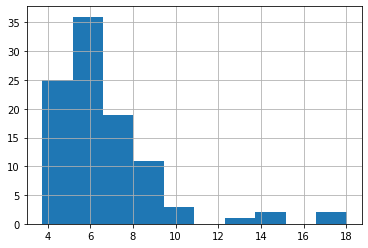

In [159]:
trade_1970.features["country_sd"].hist()

In [160]:
trade_1970.features

,index,country_code,prev_gdp_growth,current_gdp_growth,current_gdp_growth_log,future_gdp_growth,future_5y_gdp_growth,future_3y_gdp_growth,future_5y_gdp_growth_log,future_3y_gdp_growth_log,...,current_oil_rents,future_oil_rents,future_5y_oil_rents,future_3y_oil_rents,prev_coal_rents,current_coal_rents,future_coal_rents,future_5y_coal_rents,future_3y_coal_rents,node_numbers
0,2,ARG,9.679526,3.045643,4.635172,5.658131,15.603694,10.098302,23.178349,13.914432,...,0.268367,0.394583,5.216018,1.307069,0.0,0.000000,0.000000,0.010514,0.000000,0
1,3,AUS,7.043526,7.175782,4.674470,3.999615,15.968969,10.527864,23.182771,13.918928,...,0.013721,0.064334,2.994428,0.493696,0.0,0.134279,0.105050,1.715430,0.315519,1
2,4,AUT,6.275867,6.321143,4.666464,5.114969,19.791668,16.213265,23.218730,13.973369,...,0.012188,0.015245,0.472442,0.070463,0.0,0.000000,0.002451,0.044277,0.007037,2
3,5,BDI,-1.459541,21.325671,4.798478,2.746829,3.202995,3.231915,23.053048,13.843047,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3
4,6,BEL,6.629800,5.582858,4.659496,3.985827,18.262450,15.663134,23.203186,13.968060,...,0.000000,0.000000,0.000000,0.000000,0.0,0.103914,0.109288,0.544966,0.250187,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,133,VCT,2.860845,10.745890,4.707238,2.968051,1.268904,17.698204,22.995721,13.956859,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,94
95,134,VEN,0.706037,7.711914,4.679460,1.479291,14.837645,9.872054,23.171001,13.911627,...,7.003327,8.645366,89.913881,28.943684,0.0,0.000000,0.000000,0.003302,0.000000,95
96,136,ZAF,4.715903,5.248661,4.656326,4.278934,18.312265,10.505709,23.204997,13.918528,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.100993,8.137799,3.334136,96
97,137,ZMB,-0.436916,4.797113,4.652026,-0.086040,12.319606,8.160777,23.142760,13.893075,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.172108,1.322899,0.579445,97


In [53]:
%%time

networks_list = []

for year in trange(1962, 2016):
    #prepare data
    trade = TradeNetwork2(year = year)
    trade.prepare_features()
    trade.prepare_network()
    
    #merge into single list
    network_data = pd.merge(trade.features, 
                        trade.centrality_product, on = "country_code")
    network_data = pd.merge(network_data, trade.centrality_overall, on = "country_code")
    network_data = pd.merge(network_data, trade.regression_table_weighted, on = "country_code")
    network_data = pd.merge(network_data, trade.regression_table_unweighted, on = "country_code")
    
    network_data["year"] = year
    
    networks_list.append(network_data)

100%|███████████████████████████████████████████| 54/54 [33:51<00:00, 37.62s/it]

CPU times: user 27min 36s, sys: 4min 51s, total: 32min 27s
Wall time: 33min 51s


In [54]:
networks_df = pd.concat(networks_list)

In [55]:
with open('networks_ts2.pickle', 'wb') as handle:
    pkl.dump(networks_df, handle)


In [3]:
with open('networks_ts2.pickle', 'rb') as handle:
    networks_df = pkl.load(handle)

<AxesSubplot:>

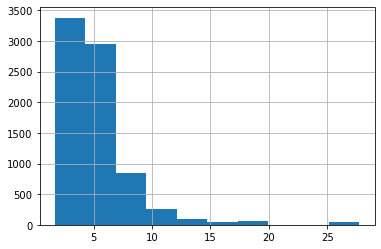

In [4]:
networks_df["country_sd"].hist()

In [5]:
high_vol_countries = networks_df[networks_df["country_sd"] > 10]["country_code"]

networks_df[networks_df["country_sd"] > 10][["country_code", "country_sd"]].drop_duplicates()


,country_code,country_sd
62,SYR,10.239661
57,OMN,14.804361
71,RWA,10.020315
43,IRQ,17.911881
75,SAU,11.641671
51,GNQ,27.737803
75,MAC,12.985825
78,LBN,14.211655
9,AZE,12.531712
55,GEO,10.024317


In [6]:
networks_df.columns

Index(['index', 'country_code', 'prev_gdp_growth', 'current_gdp_growth',
       'current_gdp_growth_log', 'future_gdp_growth', 'future_5y_gdp_growth',
       'future_3y_gdp_growth', 'future_3y_gdp_growth_norm',
       'future_5y_gdp_growth_log', 'future_3y_gdp_growth_log', 'world_growth',
       'future_5y_gdp_sd', 'country_sd', 'prev_gdp', 'current_gdp',
       'prev_gdp_per_cap', 'current_gdp_per_cap', 'future_gdp_per_cap',
       'prev_gdp_per_cap_growth', 'current_gdp_per_cap_growth',
       'future_gdp_per_cap_growth', 'future_5y_gdp_per_cap_growth',
       'future_3y_gdp_per_cap_growth', 'prev_oil_rents', 'current_oil_rents',
       'future_oil_rents', 'future_5y_oil_rents', 'future_3y_oil_rents',
       'prev_coal_rents', 'current_coal_rents', 'future_coal_rents',
       'future_5y_coal_rents', 'future_3y_coal_rents', 'node_numbers',
       'prod_0', 'prod_w_0', 'in_centrality_0', 'out_centrality_0', 'prod_3',
       'prod_w_3', 'in_centrality_3', 'out_centrality_3', 'prod_8', '

<AxesSubplot:>

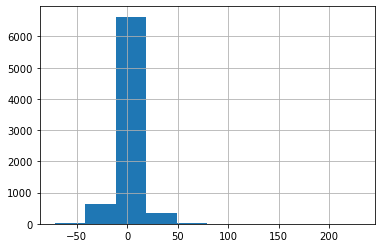

In [7]:
networks_df['future_3y_gdp_growth_norm'].hist()

# Select variants of dependent variable

In [35]:
train_years = range(1990, 2015)
test_years = range(1978,1980)

#train_years = range(1985, 1990)
#test_years = range(1998,2000)

first_year = min(train_years)

In [8]:
keep_countries = networks_df[(networks_df.country_sd <10)]["country_code"]
#keep_countries = networks_df["country_code"]

In [16]:
result = sm.ols(formula="future_3y_gdp_growth_norm~ current_gdp_growth + prev_gdp_growth ", 
                 data=networks_df[#networks_df.year.isin(train_years)& 
                                 networks_df.country_code.isin(keep_countries)].dropna()).fit()
print(result.summary())
x = result.predict()

#plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

                                OLS Regression Results                               
Dep. Variable:     future_3y_gdp_growth_norm   R-squared:                       0.108
Model:                                   OLS   Adj. R-squared:                  0.108
Method:                        Least Squares   F-statistic:                     436.1
Date:                       Sat, 04 Mar 2023   Prob (F-statistic):          1.52e-179
Time:                               12:21:06   Log-Likelihood:                -26696.
No. Observations:                       7226   AIC:                         5.340e+04
Df Residuals:                           7223   BIC:                         5.342e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [11]:
result = sm.ols(formula="future_3y_gdp_growth_norm~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + centrality_overall \
+ current_gdp_growth + prev_gdp_growth + current_gdp_growth_weighted_neighbors + \
prev_gdp_growth_weighted_neighbors", 
                 data=networks_df[#networks_df.year.isin(train_years)& 
                                 networks_df.country_code.isin(keep_countries)].dropna()).fit()
print(result.summary())
x = result.predict()

#plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

                                OLS Regression Results                               
Dep. Variable:     future_3y_gdp_growth_norm   R-squared:                       0.137
Model:                                   OLS   Adj. R-squared:                  0.135
Method:                        Least Squares   F-statistic:                     76.04
Date:                       Sat, 04 Mar 2023   Prob (F-statistic):          2.04e-216
Time:                               11:23:38   Log-Likelihood:                -26577.
No. Observations:                       7226   AIC:                         5.319e+04
Df Residuals:                           7210   BIC:                         5.330e+04
Df Model:                                 15                                         
Covariance Type:                   nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [15]:
result = sm.ols(formula="future_3y_gdp_growth_norm~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + centrality_overall \
+ current_gdp_growth + prev_gdp_growth + current_gdp_growth_weighted_neighbors + \
prev_gdp_growth_weighted_neighbors + C(country_code)", 
                 data=networks_df[#networks_df.year.isin(train_years)& 
                                 networks_df.country_code.isin(keep_countries)].dropna()).\
fit(cov_type='cluster', cov_kwds={'groups': networks_df[#networks_df.year.isin(train_years)& 
                                 networks_df.country_code.isin(keep_countries)].dropna()['country_code']})
print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_3y_gdp_growth_norm   R-squared:                       0.248
Model:                                   OLS   Adj. R-squared:                  0.227
Method:                        Least Squares   F-statistic:                     1260.
Date:                       Sat, 04 Mar 2023   Prob (F-statistic):          3.67e-178
Time:                               12:20:11   Log-Likelihood:                -26077.
No. Observations:                       7226   AIC:                         5.256e+04
Df Residuals:                           7024   BIC:                         5.395e+04
Df Model:                                201                                         
Covariance Type:                     cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

/home/semenova/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 201, but rank is 15
  warnings.warn('covariance of constraints does not have full '


In [53]:
y_test = networks_df[networks_df.year.isin(test_years) & 
                               networks_df.country_code.isin(keep_countries)].dropna()
y_test = y_test.sort_values(by = ["future_3y_gdp_growth_norm"])
x2 = result.predict(y_test)

correlation = np.corrcoef(x2, y_test["future_3y_gdp_growth_norm"])[0,1]

correlation

0.19525887811295348

In [54]:
correlation**2

0.038126029481929224

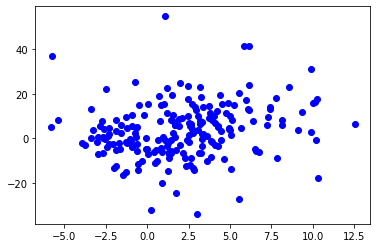

In [55]:
plt.plot(x2, y_test["future_3y_gdp_growth_norm"], 'bo')

In [40]:
def growth_type(x, growth_list):
    threshold_high = np.percentile(growth_list, 70)
    threshold_low = np.percentile(growth_list, 30)
    
    if(x > threshold_high): return 2
    elif(x< threshold_low): return 0
    else: return 1

In [43]:
networks_df_filt = networks_df

In [44]:
growth_list = list(networks_df_filt["future_3y_gdp_growth_norm"])

networks_df_filt["growth_cat"] = networks_df_filt["future_3y_gdp_growth_norm"].apply(lambda x: growth_type(x, growth_list))

In [45]:
networks_df_filt["coal_rents"] = networks_df_filt["current_coal_rents"].apply(lambda x: 1 if x>0 else 0)
networks_df_filt["oil_rents"] = networks_df_filt["current_oil_rents"].apply(lambda x: 1 if x>0 else 0)

In [46]:
import statsmodels.api as sma
Y = networks_df_filt["growth_cat"]
indep_cols = ["current_gdp_growth","prev_gdp_growth"]

X = networks_df_filt[indep_cols].dropna()

sma.MNLogit(Y, pd.get_dummies(X)).fit().summary()

Optimization terminated successfully.
         Current function value: 1.087811
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             growth_cat   No. Observations:                 1602
Model:                        MNLogit   Df Residuals:                     1598
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                0.001132
Time:                        15:20:04   Log-Likelihood:                -1742.7
converged:                       True   LL-Null:                       -1744.6
Covariance Type:            nonrobust   LLR p-value:                    0.1388
======================================================================================
      growth_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
current_gdp_growth     0.0393      0.010      3.921      0.000       0.020       0.059
prev_gdp_growth       -0.0001      0.009     -0.013      0.990      -0.019       0.018
--------------------------------------------------------------------------------------
      growth_cat=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
current_gdp_growth     0.0432      0.010      4.346      0.000       0.024       0.063
prev_gdp_growth        0.0020      0.009      0.208      0.836      -0.016       0.020
======================================================================================
"""

In [47]:
networks_df_filt["pred"] = sma.MNLogit(Y, pd.get_dummies(X)).fit().predict().argmax(1)

Optimization terminated successfully.
         Current function value: 1.087811
         Iterations 5


In [48]:
sum(networks_df_filt["pred"] == networks_df_filt["growth_cat"])

514

In [49]:
len(networks_df_filt)

1602

In [52]:
import statsmodels.api as sma
Y = networks_df_filt["growth_cat"]
indep_cols = ["prod_0","prod_1","prod_2","prod_3","prod_4","prod_5","prod_6",
"prod_7","prod_8","prod_9","centrality_overall","weighted_centrality",
"current_gdp_growth","prev_gdp_growth","current_gdp_growth_weighted_neighbors",
"prev_gdp_growth_weighted_neighbors","coal_rents","oil_rents",
"prod_w_0","prod_w_1","prod_w_2","prod_w_3","prod_w_4","prod_w_5","prod_w_6",
"prod_w_7","prod_w_8","prod_w_9"]

X = networks_df_filt[indep_cols].dropna()

sma.MNLogit(Y, pd.get_dummies(X)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.977599
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             growth_cat   No. Observations:                 1602
Model:                        MNLogit   Df Residuals:                     1546
Method:                           MLE   Df Model:                           54
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                  0.1023
Time:                        15:21:10   Log-Likelihood:                -1566.1
converged:                       True   LL-Null:                       -1744.6
Covariance Type:            nonrobust   LLR p-value:                 2.956e-46
=========================================================================================================
                         growth_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
prod_0                                   -1.9492      8.853     -0.220      0.826     -19.300      15.401
prod_1                                   -3.0757      4.586     -0.671      0.502     -12.064       5.913
prod_2                                    9.0375      7.018      1.288      0.198      -4.717      22.792
prod_3                                   -1.7380      3.726     -0.466      0.641      -9.041       5.565
prod_4                                    9.9122      4.371      2.268      0.023       1.345      18.480
prod_5                                   21.5017      8.259      2.603      0.009       5.315      37.689
prod_6                                  -18.6353     14.396     -1.294      0.196     -46.851       9.581
prod_7                                  -10.5868      9.635     -1.099      0.272     -29.472       8.298
prod_8                                   -2.0576     10.981     -0.187      0.851     -23.580      19.465
prod_9                                   -2.1968      3.857     -0.570      0.569      -9.755       5.362
centrality_overall                        2.9976     12.953      0.231      0.817     -22.390      28.385
weighted_centrality                      -1.3513      1.184     -1.141      0.254      -3.672       0.969
current_gdp_growth                        0.0218      0.012      1.879      0.060      -0.001       0.044
prev_gdp_growth                          -0.0161      0.011     -1.408      0.159      -0.039       0.006
current_gdp_growth_weighted_neighbors     0.0199      0.032      0.630      0.529      -0.042       0.082
prev_gdp_growth_weighted_neighbors       -0.0070      0.031     -0.225      0.822      -0.068       0.054
coal_rents                                0.3947      0.223      1.774      0.076      -0.041       0.831
oil_rents                                -0.1514      0.198     -0.762      0.446      -0.540       0.238
prod_w_0                                 -2.3055      2.547     -0.905      0.365      -7.297       2.686
prod_w_1                                 -3.3545      1.992     -1.684      0.092      -7.258       0.549
prod_w_2                                  2.2171      2.766      0.802      0.423      -3.204       7.638
prod_w_3                                  4.1908      2.059      2.036      0.042       0.156       8.225
prod_w_4                                 -2.2984      1.526     -1.506      0.132      -5.289       0.693
prod_w_5                                  4.1485      4.281      0.969      0.333      -4.243      12.540
prod_w_6                                 -1.0720      3.788     -0.283      0.777      -8.496       6.352
prod_w_7                                 -0.2883      3.236     -0.089      0.929      -6.631       6.054
prod_w_8                                  1.1187      3.935      0.284      0.776      -6.594       8.831
prod_w_9                                 -0.2129      1.961  

In [86]:
networks_df_filt["pred"] = sma.MNLogit(Y, pd.get_dummies(X)).fit().predict().argmax(1)

Optimization terminated successfully.
         Current function value: 1.085917
         Iterations 5


In [87]:
sum(networks_df_filt["pred"] == networks_df_filt["growth_cat"])

595

In [88]:
len(networks_df_filt)

1464

In [84]:
sum([True, True, False])

2

In [ ]:
result = sm.ols(formula="future_3y_gdp_growth_norm~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + weighted_centrality\
+ current_gdp_growth + prev_gdp_growth + current_gdp_growth_weighted_neighbors + \
prev_gdp_growth_weighted_neighbors", 
                 data=networks_df_filt[networks_df_filt.year.isin(train_years)& 
                                 networks_df_filt.country_code.isin(keep_countries)].dropna()).fit()
print(result.summary())
x = result.predict()

In [6]:
networks_df["year-1"] = networks_df["year"] - 1 
networks_df["year-2"] = networks_df["year"] - 2
networks_initial = networks_df.copy()

In [7]:
networks_df = pd.merge(networks_df, networks_initial,
                      left_on = ["country_code","year-1"],
                      right_on = ["country_code","year"],
                      suffixes = ("", "_prev1"))

networks_df = pd.merge(networks_df, networks_initial,
                      left_on = ["country_code","year-2"],
                      right_on = ["country_code","year"],
                      suffixes = ("", "_prev2"))

In [8]:
networks_df[["year", "year_prev1"]]

,year,year_prev1
0,1964,1963
1,1964,1963
2,1964,1963
3,1964,1963
4,1964,1963
...,...,...
7174,2015,2014
7175,2015,2014
7176,2015,2014
7177,2015,2014


In [9]:
train_years = range(1970, 1975)
test_years = range(1978,1980)

train_years = range(1985, 1990)
test_years = range(1998,2000)

keep_countries = networks_df["country_code"]

In [11]:
list(networks_df.columns)

['country_code',
 'prev_gdp_growth',
 'current_gdp_growth',
 'future_gdp_growth',
 'future_5y_gdp_growth',
 'future_3y_gdp_growth',
 'future_5y_gdp_sd',
 'prev_gdp',
 'current_gdp',
 'prev_gdp_per_cap',
 'current_gdp_per_cap',
 'future_gdp_per_cap',
 'prev_gdp_per_cap_growth',
 'current_gdp_per_cap_growth',
 'future_gdp_per_cap_growth',
 'future_5y_gdp_per_cap_growth',
 'future_3y_gdp_per_cap_growth',
 'prev_oil_rents',
 'current_oil_rents',
 'future_oil_rents',
 'future_5y_oil_rents',
 'future_3y_oil_rents',
 'prev_coal_rents',
 'current_coal_rents',
 'future_coal_rents',
 'future_5y_coal_rents',
 'future_3y_coal_rents',
 'prod_7',
 'prod_3',
 'prod_4',
 'prod_8',
 'prod_9',
 'prod_5',
 'prod_2',
 'prod_6',
 'prod_1',
 'prod_0',
 'centrality_overall',
 'current_gdp_growth_weighted_neighbors',
 'prev_gdp_growth_weighted_neighbors',
 'current_gdp_growth_unweighted_neighbors',
 'prev_gdp_growth_unweighted_neighbors',
 'year',
 'year-1',
 'year-2',
 'prev_gdp_growth_prev1',
 'current_gdp_

In [ ]:
result = sm.ols(formula="future_3y_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + centrality_overall \
+ current_gdp_growth + prev_gdp_growth + current_gdp_growth_weighted_neighbors + \
prev_gdp_growth_weighted_neighbors", 
                 data=networks_df[networks_df.year.isin(train_years)& 
                                 networks_df.country_code.isin(keep_countries)].dropna()).fit()
print(result.summary())
x = result.predict()

# Hypotheses: 
- we have several types of variables; we are not sure if what matters for them is the change or the variable at a point in time 

Current hypotheses:
- product_centrality -- current relationship
- overall centratlity -- change
- GDP of neighbours -- unknown 
- other independent variables: unknown 

In [23]:
list(networks_df.columns)

['country_code',
 'prev_gdp_growth',
 'current_gdp_growth',
 'future_gdp_growth',
 'future_5y_gdp_growth',
 'future_3y_gdp_growth',
 'future_5y_gdp_sd',
 'prev_gdp',
 'current_gdp',
 'prev_gdp_per_cap',
 'current_gdp_per_cap',
 'future_gdp_per_cap',
 'prev_gdp_per_cap_growth',
 'current_gdp_per_cap_growth',
 'future_gdp_per_cap_growth',
 'future_5y_gdp_per_cap_growth',
 'future_3y_gdp_per_cap_growth',
 'prev_oil_rents',
 'current_oil_rents',
 'future_oil_rents',
 'future_5y_oil_rents',
 'future_3y_oil_rents',
 'prev_coal_rents',
 'current_coal_rents',
 'future_coal_rents',
 'future_5y_coal_rents',
 'future_3y_coal_rents',
 'prod_0',
 'prod_8',
 'prod_3',
 'prod_2',
 'prod_4',
 'prod_5',
 'prod_7',
 'prod_6',
 'prod_9',
 'prod_1',
 'centrality_overall',
 'current_gdp_growth_weighted_neighbors',
 'prev_gdp_growth_weighted_neighbors',
 'current_gdp_growth_unweighted_neighbors',
 'prev_gdp_growth_unweighted_neighbors',
 'year',
 'year-1',
 'year-2',
 'prev_gdp_growth_prev1',
 'current_gdp_

In [25]:
networks_df["centrality_change"] = np.log(networks_df["centrality_overall"]) \
                                - np.log(networks_df["centrality_overall_prev2"])

networks_df["gdp_neighbours_change"] = networks_df["current_gdp_growth_weighted_neighbors"] \
                                    - networks_df["current_gdp_growth_weighted_neighbors_prev2"]

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.027
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     20.10
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):           3.51e-37
Time:                          14:54:38   Log-Likelihood:                -27495.
No. Observations:                  7179   AIC:                         5.501e+04
Df Residuals:                      7168   BIC:                         5.509e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1239      0.477

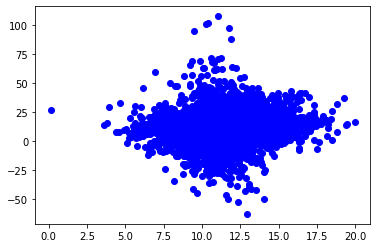

In [30]:
# result -- just product centrality
result = sm.ols(formula="future_3y_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

                            OLS Regression Results                            
Dep. Variable:      future_gdp_growth   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     8.929
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           9.32e-15
Time:                        14:59:17   Log-Likelihood:                -22335.
No. Observations:                7179   AIC:                         4.469e+04
Df Residuals:                    7168   BIC:                         4.477e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6159      0.233     15.545      0.0

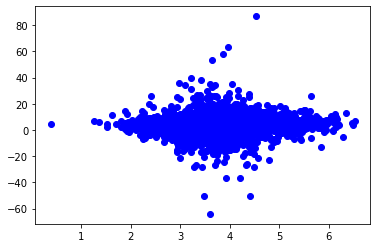

In [35]:
# result -- just product centrality
result = sm.ols(formula="future_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_5y_gdp_growth   R-squared:                       0.036
Model:                              OLS   Adj. R-squared:                  0.034
Method:                   Least Squares   F-statistic:                     26.41
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):           5.40e-50
Time:                          15:00:02   Log-Likelihood:                -30245.
No. Observations:                  7179   AIC:                         6.051e+04
Df Residuals:                      7168   BIC:                         6.059e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.4949      0.700

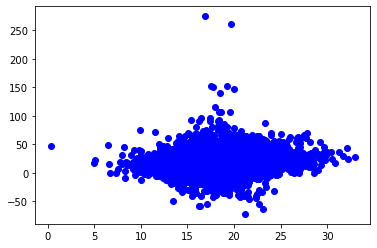

In [36]:
# result -- just product centrality
result = sm.ols(formula="future_5y_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_5y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.205
Model:                              OLS   Adj. R-squared:                  0.181
Method:                   Least Squares   F-statistic:                     8.495
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):          4.11e-216
Time:                          14:56:48   Log-Likelihood:                -26769.
No. Observations:                  7179   AIC:                         5.396e+04
Df Residuals:                      6966   BIC:                         5.543e+04
Df Model:                           212                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

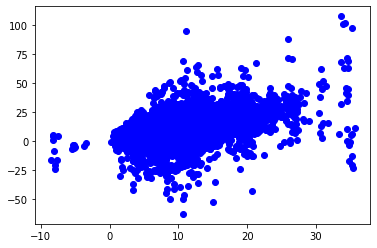

In [33]:
# result -- just product centrality
result = sm.ols(formula="future_3y_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + centrality_overall + C(country_code)", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_5y_gdp_growth   R-squared:                       0.270
Model:                              OLS   Adj. R-squared:                  0.248
Method:                   Least Squares   F-statistic:                     12.15
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                          15:00:55   Log-Likelihood:                -29246.
No. Observations:                  7179   AIC:                         5.892e+04
Df Residuals:                      6966   BIC:                         6.038e+04
Df Model:                           212                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

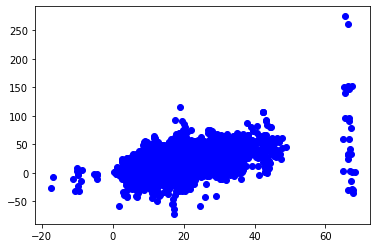

In [37]:
# result -- just product centrality
result = sm.ols(formula="future_5y_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + centrality_overall + C(country_code)", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_5y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.275
Model:                              OLS   Adj. R-squared:                  0.248
Method:                   Least Squares   F-statistic:                     9.986
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):          3.29e-315
Time:                          14:57:31   Log-Likelihood:                -26439.
No. Observations:                  7179   AIC:                         5.341e+04
Df Residuals:                      6915   BIC:                         5.522e+04
Df Model:                           263                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

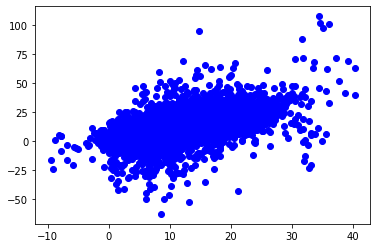

In [34]:
# result -- just product centrality
result = sm.ols(formula="future_3y_gdp_growth~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9 + centrality_overall + C(country_code) + C(year)", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

### Experiments with neighbours GDP

In [39]:
list(networks_df.columns)

['country_code',
 'prev_gdp_growth',
 'current_gdp_growth',
 'future_gdp_growth',
 'future_5y_gdp_growth',
 'future_3y_gdp_growth',
 'future_5y_gdp_sd',
 'prev_gdp',
 'current_gdp',
 'prev_gdp_per_cap',
 'current_gdp_per_cap',
 'future_gdp_per_cap',
 'prev_gdp_per_cap_growth',
 'current_gdp_per_cap_growth',
 'future_gdp_per_cap_growth',
 'future_5y_gdp_per_cap_growth',
 'future_3y_gdp_per_cap_growth',
 'prev_oil_rents',
 'current_oil_rents',
 'future_oil_rents',
 'future_5y_oil_rents',
 'future_3y_oil_rents',
 'prev_coal_rents',
 'current_coal_rents',
 'future_coal_rents',
 'future_5y_coal_rents',
 'future_3y_coal_rents',
 'prod_0',
 'prod_8',
 'prod_3',
 'prod_2',
 'prod_4',
 'prod_5',
 'prod_7',
 'prod_6',
 'prod_9',
 'prod_1',
 'centrality_overall',
 'current_gdp_growth_weighted_neighbors',
 'prev_gdp_growth_weighted_neighbors',
 'current_gdp_growth_unweighted_neighbors',
 'prev_gdp_growth_unweighted_neighbors',
 'year',
 'year-1',
 'year-2',
 'prev_gdp_growth_prev1',
 'current_gdp_

In [44]:
networks_df["growth_mod"] = np.log(networks_df["current_gdp_growth"] + 100)

<AxesSubplot:>

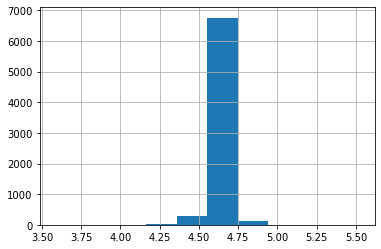

In [45]:
networks_df["growth_mod"].hist()

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.021
Model:                              OLS   Adj. R-squared:                  0.020
Method:                   Least Squares   F-statistic:                     75.48
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):           3.61e-33
Time:                          15:12:38   Log-Likelihood:                -27520.
No. Observations:                  7179   AIC:                         5.505e+04
Df Residuals:                      7176   BIC:                         5.507e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

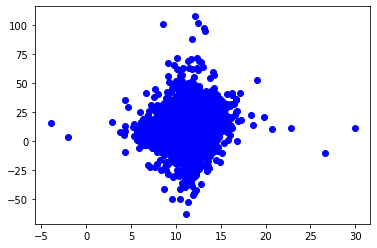

In [40]:
result = sm.ols(formula="future_3y_gdp_growth~ current_gdp_growth_weighted_neighbors + \
prev_gdp_growth_weighted_neighbors", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.269
Model:                              OLS   Adj. R-squared:                  0.243
Method:                   Least Squares   F-statistic:                     10.09
Date:                  Tue, 14 Feb 2023   Prob (F-statistic):          2.48e-309
Time:                          14:53:30   Log-Likelihood:                -26468.
No. Observations:                  7179   AIC:                         5.344e+04
Df Residuals:                      6925   BIC:                         5.519e+04
Df Model:                           253                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

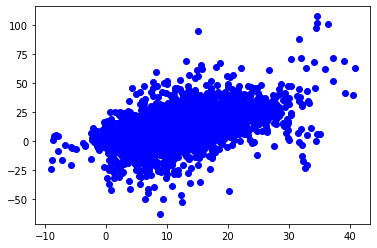

In [29]:
result = sm.ols(formula="future_3y_gdp_growth~ centrality_change + C(country_code) + C(year)", 
                 data=networks_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, networks_df["future_3y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_5y_gdp_growth   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                 -0.009
Method:                   Least Squares   F-statistic:                    0.1176
Date:                  Wed, 08 Feb 2023   Prob (F-statistic):              0.732
Time:                          12:33:11   Log-Likelihood:                -418.28
No. Observations:                    99   AIC:                             840.6
Df Residuals:                        97   BIC:                             845.8
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

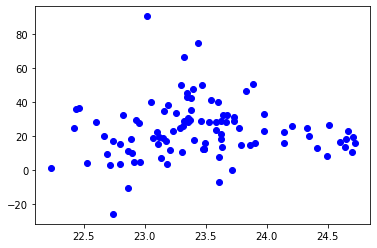

In [380]:
result = sm.ols(formula="future_5y_gdp_growth ~ centrality_overall", 
                 data=reg2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg2["future_5y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.075
Model:                              OLS   Adj. R-squared:                 -0.042
Method:                   Least Squares   F-statistic:                    0.6373
Date:                  Sun, 12 Feb 2023   Prob (F-statistic):              0.792
Time:                          14:30:10   Log-Likelihood:                -381.71
No. Observations:                    99   AIC:                             787.4
Df Residuals:                        87   BIC:                             818.6
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

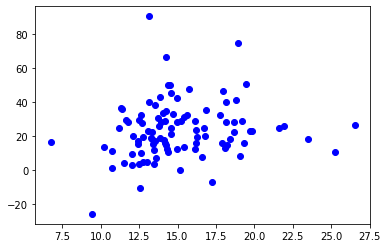

In [437]:
result = sm.ols(formula="future_3y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall", 
                 data=reg2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg2["future_5y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_5y_gdp_growth   R-squared:                       0.055
Model:                              OLS   Adj. R-squared:                 -0.064
Method:                   Least Squares   F-statistic:                    0.4632
Date:                  Sun, 12 Feb 2023   Prob (F-statistic):              0.921
Time:                          14:31:03   Log-Likelihood:                -415.53
No. Observations:                    99   AIC:                             855.1
Df Residuals:                        87   BIC:                             886.2
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

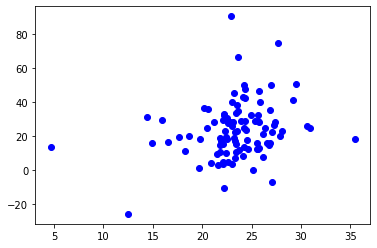

In [438]:
trade_1970 = TradeNetwork2(year = 1970)
trade_1970.prepare_features()
trade_1970.prepare_network(weighted_prod_network = True)

reg2 = pd.merge(trade_1970.features, trade_1970.centrality_product, on = "country_code")
reg2 = pd.merge(reg2, trade_1970.centrality_overall, on = "country_code")

result = sm.ols(formula="future_5y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall", 
                 data=reg2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg2["future_5y_gdp_growth"], 'bo')

# Look at change in centrality in different product spaces

In [385]:
trade_1970 = TradeNetwork2(year = 1970)
trade_1970.prepare_features()
trade_1970.prepare_network()

trade_1971 = TradeNetwork2(year = 1971)
trade_1971.prepare_features()
trade_1971.prepare_network()

trade_1972 = TradeNetwork2(year = 1972)
trade_1972.prepare_features()
trade_1972.prepare_network()


In [392]:
prod_diff = pd.merge(trade_1970.centrality_product, trade_1972.centrality_product,
                  on = "country_code", suffixes = ("", "_2"))

for col in trade_1972.centrality_product.columns:
    if (col == "country_code"): continue
    else:
        prod_diff[col] = np.log(prod_diff[col]) - np.log(prod_diff[col + "_2"])
        
prod_diff = prod_diff[trade_1972.centrality_product.columns]

centrality_diff = pd.merge(trade_1970.centrality_overall, trade_1972.centrality_overall,
                  on = "country_code", suffixes = ("", "_2"))

centrality_diff["centrality_overall"] = np.log(centrality_diff["centrality_overall"]) - \
                                        np.log(centrality_diff["centrality_overall_2"])
centrality_diff = centrality_diff[["country_code", "centrality_overall"]]

In [393]:
reg_df = pd.merge(prod_diff, centrality_diff, on = "country_code")

reg_df = pd.merge(reg_df, trade_1972.features, on = "country_code")

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.154
Model:                              OLS   Adj. R-squared:                  0.047
Method:                   Least Squares   F-statistic:                     1.439
Date:                  Wed, 08 Feb 2023   Prob (F-statistic):              0.170
Time:                          14:59:49   Log-Likelihood:                -377.37
No. Observations:                    99   AIC:                             778.7
Df Residuals:                        87   BIC:                             809.9
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

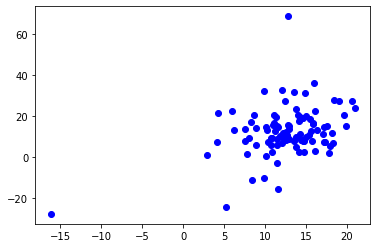

In [395]:
result = sm.ols(formula="future_3y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall", 
                 data=reg_df.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg_df["future_3y_gdp_growth"], 'bo')

In [396]:
reg_df2 = pd.merge(trade_1972.centrality_product, centrality_diff, on = "country_code")

reg_df2 = pd.merge(reg_df2, trade_1972.features, on = "country_code")

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.227
Model:                              OLS   Adj. R-squared:                  0.130
Method:                   Least Squares   F-statistic:                     2.326
Date:                  Wed, 08 Feb 2023   Prob (F-statistic):             0.0148
Time:                          15:17:41   Log-Likelihood:                -372.88
No. Observations:                    99   AIC:                             769.8
Df Residuals:                        87   BIC:                             800.9
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

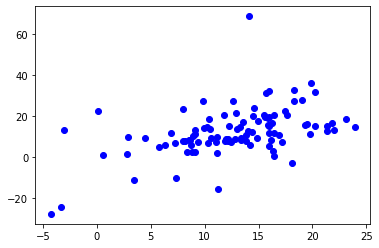

In [400]:
result = sm.ols(formula="future_3y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall", 
                 data=reg_df2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg_df2["future_3y_gdp_growth"], 'bo')

(-32.35015000191655, 73.67915769363523)

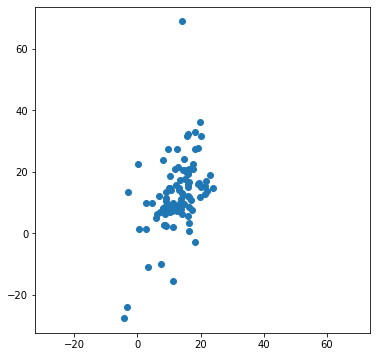

In [401]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, reg_df2["future_3y_gdp_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

In [442]:
reg_df2.columns

Index(['country_code', 'prod_6', 'prod_4', 'prod_3', 'prod_2', 'prod_9',
       'prod_5', 'prod_1', 'prod_8', 'prod_7', 'prod_0', 'centrality_overall',
       'prev_gdp_growth', 'current_gdp_growth', 'future_gdp_growth',
       'future_5y_gdp_growth', 'future_3y_gdp_growth', 'future_5y_gdp_sd',
       'prev_gdp', 'current_gdp', 'prev_gdp_per_cap', 'current_gdp_per_cap',
       'future_gdp_per_cap', 'prev_gdp_per_cap_growth',
       'current_gdp_per_cap_growth', 'future_gdp_per_cap_growth',
       'future_5y_gdp_per_cap_growth', 'future_3y_gdp_per_cap_growth',
       'prev_oil_rents', 'current_oil_rents', 'future_oil_rents',
       'future_5y_oil_rents', 'future_3y_oil_rents', 'prev_coal_rents',
       'current_coal_rents', 'future_coal_rents', 'future_5y_coal_rents',
       'future_3y_coal_rents'],
      dtype='object')

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.089
Model:                              OLS   Adj. R-squared:                  0.070
Method:                   Least Squares   F-statistic:                     4.692
Date:                  Sun, 12 Feb 2023   Prob (F-statistic):             0.0114
Time:                          14:37:40   Log-Likelihood:                -381.03
No. Observations:                    99   AIC:                             768.1
Df Residuals:                        96   BIC:                             775.8
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

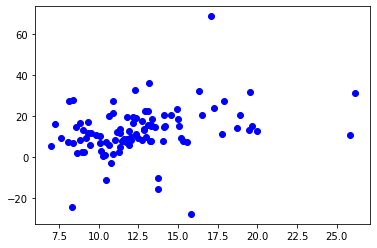

In [443]:
result = sm.ols(formula="future_3y_gdp_growth ~ current_gdp_growth + prev_gdp_growth", 
                 data=reg_df2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg_df2["future_3y_gdp_growth"], 'bo')

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.318
Model:                              OLS   Adj. R-squared:                  0.213
Method:                   Least Squares   F-statistic:                     3.043
Date:                  Sun, 12 Feb 2023   Prob (F-statistic):            0.00101
Time:                          14:43:49   Log-Likelihood:                -366.73
No. Observations:                    99   AIC:                             761.5
Df Residuals:                        85   BIC:                             797.8
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

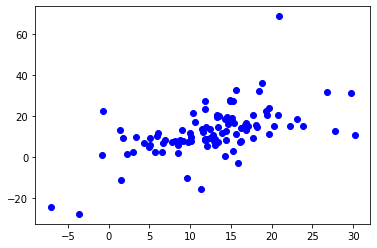

In [447]:
result = sm.ols(formula="future_3y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall + current_gdp_growth + prev_gdp_growth", 
                 data=reg_df2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg_df2["future_3y_gdp_growth"], 'bo')

(-24.82093379869608, 97.46116785704345)

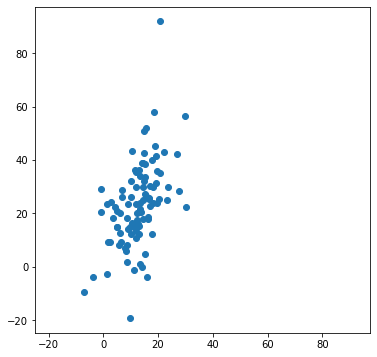

In [445]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, reg_df2["future_5y_gdp_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

                             OLS Regression Results                             
Dep. Variable:     future_5y_gdp_growth   R-squared:                       0.187
Model:                              OLS   Adj. R-squared:                  0.084
Method:                   Least Squares   F-statistic:                     1.818
Date:                  Wed, 08 Feb 2023   Prob (F-statistic):             0.0628
Time:                          15:02:54   Log-Likelihood:                -402.49
No. Observations:                    99   AIC:                             829.0
Df Residuals:                        87   BIC:                             860.1
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

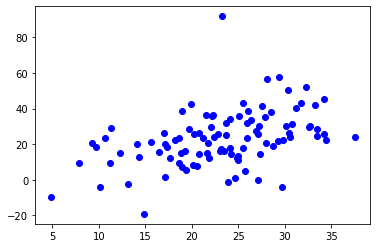

In [398]:
result = sm.ols(formula="future_5y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall", 
                 data=reg_df2.dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg_df2["future_5y_gdp_growth"], 'bo')

(-24.82093379869608, 97.46116785704345)

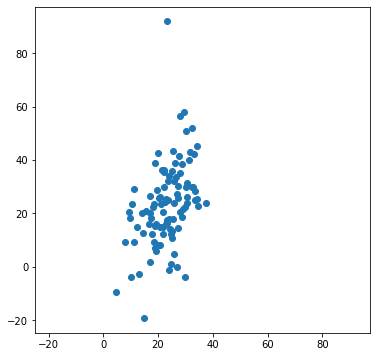

In [399]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, reg_df2["future_5y_gdp_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

                             OLS Regression Results                             
Dep. Variable:     future_3y_gdp_growth   R-squared:                       0.200
Model:                              OLS   Adj. R-squared:                  0.089
Method:                   Least Squares   F-statistic:                     1.799
Date:                  Wed, 08 Feb 2023   Prob (F-statistic):             0.0680
Time:                          15:21:28   Log-Likelihood:                -313.40
No. Observations:                    91   AIC:                             650.8
Df Residuals:                        79   BIC:                             680.9
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

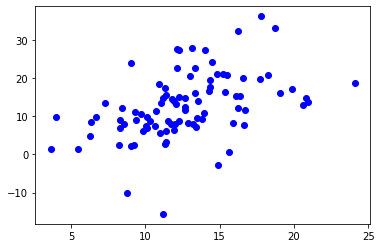

In [404]:
result = sm.ols(formula="future_3y_gdp_growth ~ prod_0+prod_1+prod_2+prod_3+prod_4+prod_5+prod_6+\
prod_7+prod_8+prod_9+centrality_overall", 
                 data=reg_df2[reg_df2["future_5y_gdp_sd"] < 10].dropna()).fit()
print(result.summary())
x = result.predict()

plt.plot(x, reg_df2[reg_df2["future_5y_gdp_sd"] < 10].dropna()["future_3y_gdp_growth"], 'bo')

(-18.143727365576503, 38.71587305316446)

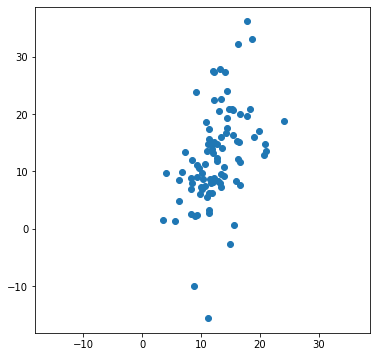

In [405]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x, reg_df2[reg_df2["future_5y_gdp_sd"] < 10].dropna()["future_3y_gdp_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

### Distribution of Labels

In [387]:
trade_1972.centrality_product.columns

Index(['country_code', 'prod_6', 'prod_4', 'prod_3', 'prod_2', 'prod_9',
       'prod_5', 'prod_1', 'prod_8', 'prod_7', 'prod_0'],
      dtype='object')

In [138]:
prod = '0'
temp = trade_1970.export_types[trade_1970.export_types["product_category"] == prod]

In [139]:
temp.sort_values(by = 'product_export_fraction')

,product_category,import_product_total,importer_code,exporter_code,import_value,product_export_fraction
119,0,3.996775e+10,AUT,KOR,7.320000e+02,0.000002
2476,0,3.996775e+10,SGP,SDN,9.920000e+02,0.000002
764,0,3.996775e+10,EGY,MYS,1.094000e+03,0.000003
2225,0,3.996775e+10,PER,CHN,1.198000e+03,0.000003
498,0,3.996775e+10,COD,CMR,1.224000e+03,0.000003
...,...,...,...,...,...,...
1036,0,3.996775e+10,GBR,DNK,8.098527e+08,2.026265
1475,0,3.996775e+10,ITA,FRA,8.258144e+08,2.066202
2848,0,3.996775e+10,USA,BRA,1.027728e+09,2.571392
2884,0,3.996775e+10,USA,MEX,1.117141e+09,2.795105


In [143]:
G=nx.from_pandas_edgelist(temp, 
                          "importer_code", "exporter_code", ["product_export_fraction"], 
                          create_using = nx.DiGraph())
centrality1971= nx.eigenvector_centrality(G,weight = 'export_percent', max_iter= 10000) 
centrality1971 = pd.DataFrame(list(map(list, centrality1971.items())), columns = ["country_code", "centrality2"])

In [144]:
centrality1971

,country_code,centrality2
0,ARG,0.149997
1,AUS,0.155205
2,AUT,0.144993
3,BEL,0.192049
4,BOL,0.052365
...,...,...
94,OMN,0.012046
95,PYF,0.009180
96,SLE,0.029699
97,SYC,0.009278


# Regression - Playground for Testing Features

In [253]:
for year in [1965, 1966, 1976, 1968, 1969, 1970]:
    trade = TradeNetwork(year = year)
    trade.prepare_features()
    trade.prepare_network()
    trade.graph_create()
    
    trade.regression_table["exporter_code"] = trade.regression_table["exporter_code"] + str(year)
    
    if(year == 1965):
        reg_table = trade.regression_table
    else:
        reg_table = reg_table.append(trade.regression_table)
    if(year == 1970):
        val_table = trade.regression_table

In [260]:
year = 1975
trade = TradeNetwork(year = year)
trade.prepare_features()
trade.prepare_network()
trade.graph_create()

val_table = trade.regression_table

In [199]:
reg_table_2_code = reg_table

In [197]:
reg_table_1_code = reg_table

In [254]:
def neighbor_regression(regression_table, agg_col = "export_percent",
                       pred = "future_gdp_growth",
                       neighbour = ["current_gdp_per_cap_growth", "prev_gdp_growth"],
                       AR = True, return_reg_table_pre_agg = False, return_reg_table_post_agg = False,
                       return_predictions = True, val_table = None):
    if(agg_col == "export_percent"):
        aggregate_to = "exporter_code"
    
    cols_for_neighbors = []
    for col in neighbour: 
        regression_table[col + "_weighted_neighbors"] = regression_table[col + "_neighbors"] * regression_table[agg_col]
        cols_for_neighbors.append(col + "_weighted_neighbors")
    
    
    group_cols1 = [aggregate_to]
    group_cols1.extend(neighbour)
    group_cols1.append(pred)
    
    #return regression_table
    if(return_reg_table_pre_agg):
        return regression_table
    
    regression_table = regression_table.groupby(group_cols1)[cols_for_neighbors].agg(["sum"]).reset_index()
    
    group_cols2 = group_cols1.copy()
    group_cols2.extend(cols_for_neighbors)
    regression_table.columns = group_cols2
    
    if(return_reg_table_post_agg):
        return regression_table
    
    formula = pred + " ~ "

    cols_for_prediction = []
    
    if(AR):
        for col in neighbour:
            cols_for_prediction.append(col)
            formula = formula + col + "+"

    for col in cols_for_neighbors:
        cols_for_prediction.append(col)
        formula = formula + col + "+"
    #formula  = formula [:-1]
    formula = formula + "0"
    
    print(formula)
    
    result = sm.ols(formula=formula, 
             data=regression_table).fit()

    print(result.summary())
    
    if(return_predictions):
        pred = result.predict(regression_table[cols_for_prediction])
        return (pred, regression_table)
    
    if(val_table is not None ):
        print("validating")
        for col in neighbour: 
            val_table[col + "_weighted_neighbors"] = val_table[col + "_neighbors"] * val_table[agg_col]

        val_table = val_table.groupby(group_cols1)[cols_for_neighbors].agg(["sum"]).reset_index()
        val_table.columns = group_cols2
        
        pred = result.predict(val_table[cols_for_prediction])
        return (pred, val_table)

In [236]:
val_table["exporter_code"]

0       AUS1970
1       AUT1970
2       BEL1970
3       BHS1970
4       BOL1970
         ...   
3638    FRA1970
3639    GBR1970
3640    MWI1970
3641    USA1970
3642    ZMB1970
Name: exporter_code, Length: 3643, dtype: object

In [320]:
pred, aggregated_reg_table =  neighbor_regression(reg_table.fillna(0),
                                neighbour = ['prev_gdp_per_cap_growth', 'current_gdp_per_cap_growth',
'resource_0', 'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5', 'resource_6', 'resource_7',
       'resource_8', 'resource_9'],
                                 pred = "future_gdp_per_cap_growth", val_table = val_table.fillna(0),
                                                 return_predictions = False)

future_gdp_per_cap_growth ~ prev_gdp_per_cap_growth+current_gdp_per_cap_growth+resource_0+resource_1+resource_2+resource_3+resource_4+resource_5+resource_6+resource_7+resource_8+resource_9+prev_gdp_per_cap_growth_weighted_neighbors+current_gdp_per_cap_growth_weighted_neighbors+resource_0_weighted_neighbors+resource_1_weighted_neighbors+resource_2_weighted_neighbors+resource_3_weighted_neighbors+resource_4_weighted_neighbors+resource_5_weighted_neighbors+resource_6_weighted_neighbors+resource_7_weighted_neighbors+resource_8_weighted_neighbors+resource_9_weighted_neighbors+0
                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.138
Model:                                   OLS   Adj. R-squared:                  0.101
Method:                        Least Squares   F-statistic:                     3.762
Date:                       Wed, 14 Dec 2022   Prob (F-statistic):          

In [223]:
aggregated_reg_table 

,exporter_code,prev_gdp_per_cap_growth,current_gdp_per_cap_growth,resource_00,resource_01,resource_02,resource_03,resource_04,resource_05,resource_06,...,resource_85_weighted_neighbors,resource_87_weighted_neighbors,resource_88_weighted_neighbors,resource_89_weighted_neighbors,resource_91_weighted_neighbors,resource_93_weighted_neighbors,resource_94_weighted_neighbors,resource_95_weighted_neighbors,resource_96_weighted_neighbors,resource_97_weighted_neighbors
0,ARG1965,8.437244,8.896809,0.021189,0.191341,0.008777,0.000820,0.409922,0.039845,0.006036,...,0.008939,0.007162,0.006697,0.029652,0.003429,0.007934,0.000101,0.003961,0.000215,0.000000
1,ARG1966,8.896809,-2.136478,0.017348,0.225533,0.007400,0.000682,0.348456,0.039070,0.009484,...,0.010019,0.007225,0.007177,0.030592,0.002945,0.007311,0.000105,0.002800,0.000138,0.000000
2,ARG1968,1.678435,3.286938,0.025965,0.193749,0.002969,0.001061,0.276442,0.057245,0.012073,...,0.011838,0.007997,0.006741,0.027345,0.001770,0.007766,0.000137,0.002840,0.000132,0.000000
3,ARG1969,3.286938,8.050279,0.023495,0.205453,0.004280,0.000997,0.313096,0.049681,0.007009,...,0.014438,0.008255,0.008204,0.029684,0.001990,0.007592,0.000144,0.002277,0.000166,0.000000
4,ARG1976,-1.587829,-3.506391,0.002902,0.119377,0.012046,0.011830,0.273913,0.084869,0.018446,...,0.014747,0.008655,0.008771,0.025221,0.000551,0.007242,0.000091,0.001615,0.000023,0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,ZWE1965,-4.403385,1.430334,0.000207,0.062098,0.000009,0.000131,0.000421,0.005581,0.030054,...,0.007279,0.011067,0.009620,0.038222,0.010025,0.008957,0.000121,0.004272,0.000702,0.000000
461,ZWE1966,1.430334,-1.818169,0.000875,0.030412,0.005173,0.000228,0.006832,0.007055,0.039405,...,0.004130,0.005011,0.004957,0.017695,0.002345,0.004470,0.000064,0.001094,0.000093,0.000000
462,ZWE1968,4.819220,-1.374107,0.003776,0.006126,0.018433,0.000000,0.002467,0.011538,0.018378,...,0.002394,0.004480,0.004026,0.011036,0.001632,0.009578,0.000052,0.000750,0.000022,0.000000
463,ZWE1969,-1.374107,8.701580,0.003686,0.015899,0.031079,0.001189,0.005142,0.004998,0.002284,...,0.006730,0.000519,0.000729,0.002269,0.002041,0.002787,0.000009,0.000126,0.000012,0.000000


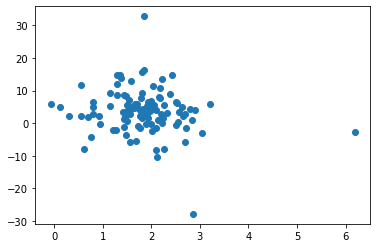

In [262]:
plt.scatter(pred, aggregated_reg_table["future_gdp_per_cap_growth"])

(-30.856814197901453, 35.81370408617056)

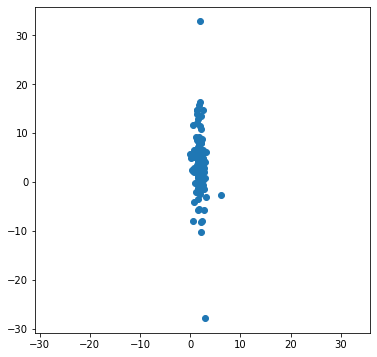

In [263]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pred, aggregated_reg_table["future_gdp_per_cap_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

In [264]:
np.corrcoef(pred, aggregated_reg_table["future_gdp_per_cap_growth"])[0,1]**2

0.023212796599265423

# Graph Setup

In [536]:
%%time

years = range(1970,1985)

val_years = [1983]
test_years = [1984]

train_graphs = []
val_graphs = []
test_graphs = []
i = 0

for year in years:
    print(str(year), end='\r')
    
    trade = TradeNetwork(year = year)
    trade.prepare_features()
    trade.prepare_network()
    trade.graph_create(node_features = ['prev_gdp_per_cap_growth', 'current_gdp_per_cap_growth',
    'resource_0', 'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5', 'resource_6', 'resource_7',
       'resource_8', 'resource_9'],
        node_labels = 'future_gdp_per_cap_growth')
    
    if(year in val_years):
        val_graphs.append(trade.pyg_graph)
    elif(year in test_years):
        test_graphs.append(trade.pyg_graph)
    else: 
        train_graphs.append(trade.pyg_graph)
        
    trade.features["year"] = year
    
    if(i == 0):
        trade_df = trade.features
    else: 
        trade_df = trade_df.append(trade.features)
        
    i = i+1
    print(trade.node_attributes.size())

torch.Size([99, 12])
torch.Size([99, 12])
torch.Size([108, 12])
torch.Size([108, 12])
torch.Size([108, 12])
torch.Size([108, 12])
torch.Size([110, 12])
torch.Size([112, 12])
torch.Size([114, 12])
torch.Size([119, 12])
torch.Size([119, 12])
torch.Size([121, 12])
torch.Size([130, 12])
torch.Size([133, 12])
torch.Size([136, 12])
CPU times: user 4min 4s, sys: 22 s, total: 4min 26s
Wall time: 4min 30s


In [537]:
test_batch = data.Batch().from_data_list(test_graphs)
val_batch = data.Batch().from_data_list(val_graphs)
train_batch = data.Batch().from_data_list(train_graphs)

In [538]:
trade_df.columns

Index(['index', 'country_code', 'prev_gdp_growth', 'current_gdp_growth',
       'future_gdp_growth', 'prev_gdp', 'current_gdp', 'prev_gdp_per_cap',
       'current_gdp_per_cap', 'future_gdp_per_cap', 'prev_gdp_per_cap_growth',
       'current_gdp_per_cap_growth', 'future_gdp_per_cap_growth', 'resource_0',
       'resource_1', 'resource_2', 'resource_3', 'resource_4', 'resource_5',
       'resource_6', 'resource_7', 'resource_8', 'resource_9', 'node_numbers',
       'year'],
      dtype='object')

In [539]:
result = sm.ols(formula='future_gdp_per_cap_growth~ current_gdp_per_cap_growth+prev_gdp_per_cap_growth', 
             data=trade_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.081
Model:                                   OLS   Adj. R-squared:                  0.080
Method:                        Least Squares   F-statistic:                     75.94
Date:                       Wed, 14 Dec 2022   Prob (F-statistic):           2.48e-32
Time:                               17:05:12   Log-Likelihood:                -5484.0
No. Observations:                       1724   AIC:                         1.097e+04
Df Residuals:                           1721   BIC:                         1.099e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

# PyG Model Definition

In [540]:
from torch_geometric.nn import GATv2Conv, GATConv, GCNConv
import torch.nn.functional as F
import torch_geometric.transforms as T

In [541]:
#test_batch.transform = T.NormalizeFeatures()
#val_batch.transform = T.NormalizeFeatures()
#train_batch.transform = T.NormalizeFeatures()

In [574]:
class GNN(torch.nn.Module):
    def __init__(self, num_features, num_edge_features,
                 hidden_dim = 10, num_heads = 40, out_feats = 10,drop = 0.2):
        super(GNN, self).__init__()
        self.num_features = num_features
        self.num_edge_features = num_edge_features
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.out_feats = out_feats
        self.drop = drop
        
        
        self.conv1 = GCNConv(self.num_features, self.out_feats, add_self_loops = False, bias = False)
        
        #self.conv1 = GATConv(self.num_features, self.out_feats, heads=self.num_heads, 
        #                       dropout=self.drop, edge_dim = self.num_edge_features, 
        #                     bias = False, add_self_loops = True)
        
        self.linear1 = nn.Linear(self.num_features, 1)
        
        #self.linear2= nn.Linear(self.out_feats*self.num_heads + 1,1, bias = True)
        self.linear2= nn.Linear(self.out_feats,1, bias = True)

    def forward(self, x, edge_index, edge_weight):
        #x, edge_index = data.x, data.edge_index
        
        #x = F.dropout(x, p=self.drop, training=self.training)
        x = self.conv1(x, edge_index, edge_weight)
        #x = F.elu(x)
        #x = F.dropout(x, p=self.drop, training=self.training)
        #x = self.conv2(x, edge_index)
        #x2 = self.linear1(x2)
        #self.linear2(torch.cat((x2,x),1))
        return self.linear2(x)
    
    def reset(self):
        self.linear2.reset_parameters()
        self.conv1.reset_parameters()

In [575]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

loss_fn = torch.nn.MSELoss(reduction = "mean")
model = GNN(num_features = train_batch.num_features, 
            num_edge_features = train_batch.num_edge_features).to(device)
#model = GNN(num_features = train_batch.num_features, 
#            num_edge_features = train_batch.num_edge_features).to(device)
model.reset()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_mse = []
valid_mse = []
best_val_mse = np.inf 
best_model = None
i = 0 
model.train()

for epoch in trange(4000):
    model.train()
    optimizer.zero_grad()
    out = model.forward(train_batch.x, train_batch.edge_index, train_batch.edge_attr)
    #print(out)
    loss = loss_fn(out.to(torch.float).flatten(), train_batch.y)
    train_mse.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    #validation
    model.eval()
    out_val = model(val_batch.x, val_batch.edge_index, val_batch.edge_attr)
    current_val_mse = loss_fn(out_val.to(torch.float).flatten(), val_batch.y).item()
    valid_mse.append(current_val_mse)
    
    #print(model.linear1.weight)
    
   # # early stopping 
    if current_val_mse < best_val_mse:
        best_val_mse = current_val_mse
        best_weights = model.state_dict()
        best_iteration = i
    
    i = i+1

100%|███████████████████████████████████████| 4000/4000 [02:31<00:00, 26.43it/s]


In [560]:
best_iteration

239

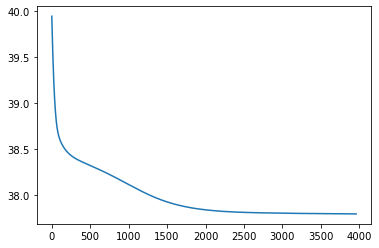

In [576]:
plt.plot(train_mse[40:])

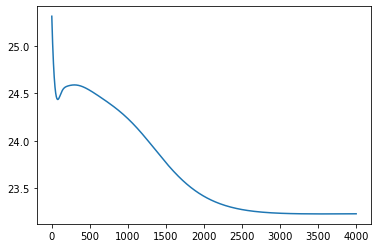

In [577]:
plt.plot(valid_mse)

In [578]:
model.load_state_dict(best_weights)
out_val = model(val_batch.x, val_batch.edge_index, val_batch.edge_attr)
valid_out_list = [item for sublist in out_val.tolist() for item in sublist]
valid_df = trade_df[trade_df.year.isin(val_years)]
valid_df["pred"] = valid_out_list

/tmp/ipykernel_1373438/387021926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["pred"] = valid_out_list


In [579]:
valid_df

,index,country_code,prev_gdp_growth,current_gdp_growth,future_gdp_growth,prev_gdp,current_gdp,prev_gdp_per_cap,current_gdp_per_cap,future_gdp_per_cap,...,resource_3,resource_4,resource_5,resource_6,resource_7,resource_8,resource_9,node_numbers,year,pred
0,2,AGO,0.000000,4.200001,6.000002,-0.344494,-0.316559,619.959903,623.440047,637.715098,...,9.669948,0.000000,0.000519,0.005412,0.007459,0.002400,0.024973,0,1983,0.480781
1,3,AND,1.246461,1.770118,1.784687,-1.235474,-1.267204,9610.020616,8025.207641,7728.906695,...,0.055203,0.003099,0.094196,2.465849,2.272600,1.914061,0.124961,1,1983,-0.063039
2,5,ARE,-6.719316,-4.745821,4.016951,0.359799,0.346322,40025.822624,34843.159626,32309.832713,...,9.244663,0.002089,0.028120,0.349803,0.124311,0.102205,0.038545,2,1983,1.248557
3,6,ARG,-0.735659,4.349093,1.570739,0.555838,0.640285,2927.897357,3553.377509,2659.708242,...,0.080409,0.719742,0.575831,0.959789,0.516924,0.132742,0.047231,3,1983,1.429152
4,7,ATG,-0.084012,5.364016,10.164996,-1.509220,-1.461880,2660.558091,2948.317275,3372.602070,...,0.000000,0.000000,0.330333,1.409294,1.302109,6.096207,0.004043,4,1983,-1.455333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,179,VEN,-2.071006,-3.764817,1.442165,0.483416,0.497463,4228.902648,4108.481006,3555.806233,...,7.977507,0.022214,0.384118,1.012529,0.072326,0.027783,0.116498,128,1983,0.269555
129,180,VUT,1.979883,3.009629,9.574991,-1.628860,-1.607376,943.194390,945.066573,1137.138278,...,0.000000,0.000000,0.000000,0.007115,0.000000,0.040526,0.000000,129,1983,0.897550
130,182,ZAF,-0.383419,-1.846558,5.099152,0.562046,0.614545,2849.180570,3103.983020,2665.386369,...,1.182575,0.022561,0.724303,3.171675,0.185134,0.641042,0.538092,130,1983,1.163298
131,183,ZMB,-2.812783,-1.966689,-0.336835,-0.453336,-0.510946,637.545690,496.197754,408.777920,...,0.020058,0.000733,0.005787,9.282008,0.043878,0.025820,0.008154,131,1983,1.393661


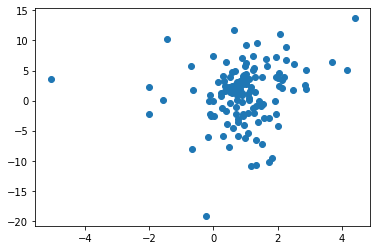

In [580]:
plt.scatter(valid_df["pred"], valid_df["future_gdp_per_cap_growth"])

(-20.82362341641022, 15.33352666269962)

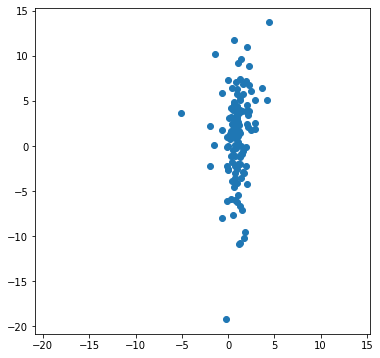

In [581]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(valid_df["pred"], valid_df["future_gdp_per_cap_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

In [582]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ pred +current_gdp_per_cap_growth + prev_gdp_per_cap_growth', 
             data=valid_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.164
Model:                                   OLS   Adj. R-squared:                  0.145
Method:                        Least Squares   F-statistic:                     8.456
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):           3.59e-05
Time:                               15:24:16   Log-Likelihood:                -387.74
No. Observations:                        133   AIC:                             783.5
Df Residuals:                            129   BIC:                             795.0
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [583]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ pred', 
             data=valid_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.031
Model:                                   OLS   Adj. R-squared:                  0.024
Method:                        Least Squares   F-statistic:                     4.207
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):             0.0422
Time:                               15:24:17   Log-Likelihood:                -397.58
No. Observations:                        133   AIC:                             799.2
Df Residuals:                            131   BIC:                             804.9
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [569]:
#evaluate on test set
#evaluate on test set
model.load_state_dict(best_weights)
out_val = model(test_batch.x, test_batch.edge_index, test_batch.edge_attr)
test_out_list = [item for sublist in out_val.tolist() for item in sublist]
test_df = trade_df[trade_df.year.isin(test_years)]
test_df["pred"] = test_out_list

/tmp/ipykernel_1373438/1946012134.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred"] = test_out_list


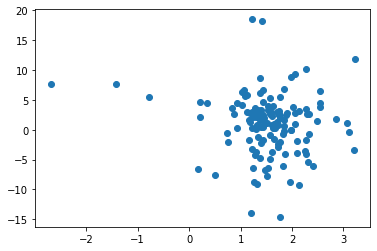

In [570]:
plt.scatter(test_df["pred"], test_df["future_gdp_per_cap_growth"])

(-16.26411981185805, 20.15342023789545)

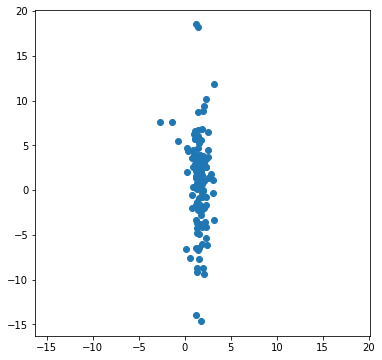

In [571]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_df["pred"], test_df["future_gdp_per_cap_growth"])
lower = min(ax.get_xlim()[0], ax.get_ylim()[0])
upper = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

In [572]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ pred', 
             data=test_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.012
Model:                                   OLS   Adj. R-squared:                  0.005
Method:                        Least Squares   F-statistic:                     1.623
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):              0.205
Time:                               14:58:09   Log-Likelihood:                -410.46
No. Observations:                        136   AIC:                             824.9
Df Residuals:                            134   BIC:                             830.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [573]:
result = sm.ols(formula='future_gdp_per_cap_growth ~ current_gdp_per_cap_growth+prev_gdp_per_cap_growth +pred', 
             data=test_df).fit()

print(result.summary())

                                OLS Regression Results                               
Dep. Variable:     future_gdp_per_cap_growth   R-squared:                       0.163
Model:                                   OLS   Adj. R-squared:                  0.144
Method:                        Least Squares   F-statistic:                     8.581
Date:                       Fri, 16 Dec 2022   Prob (F-statistic):           3.02e-05
Time:                               14:58:09   Log-Likelihood:                -399.16
No. Observations:                        136   AIC:                             806.3
Df Residuals:                            132   BIC:                             818.0
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

### Hyperparameter Tuning of a Simple Model

In [397]:
learning_rates = [0.0005, 0.0001, 0.001]
attn_drop_rates = [0, 0.1]
feat_drop_rates = [0, 0.1]
num_heads_list = [10, 20, 50, 100]
num_feat_list = [5, 10, 20, 50]
num_epochs_list = [500, 10000]

list_model_params = []

for lr in learning_rates:
    for attn_drop in attn_drop_rates:
        for feat_drop in feat_drop_rates:
            for num_heads in num_heads_list:
                for num_feats in num_feat_list:
                    
                    
                    

IndentationError: expected an indented block (3182354760.py, line 17)

In [ ]:
class NodeRegressor(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, out_feats = 1)
        #self.pooling = AvgPooling()
        #self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        #self.reg_input_dim = reg_input_dim
        #self.dropout = nn.Dropout(0.8)
        #self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        #self.linear_comb = nn.Linear(2,1)
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x = self.pooling(graph, x)
        x = self.MLP(x)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        x = torch.cat((x,out),1)
        #return x, reg_data
        x = self.linear_comb(x)
        #print(x.dtype)
        return x

# Hyperparameter Tuning - Experimenting with Performance

In [ ]:
#create function to make graphs compatible with regression tables
def pred_group_for_graphs(gnn_table, lookbacks):
    """ gnn_table: graph table, as generated by gm.submissions_agg 
        lookbacks: number of lookbacks in gnn_table
        
        In order to merge with dependent variable and to ensure a walk-between equivalently structured regression, 
        need to create "pred_group" column. "pred_group" and "ticker" are two columns that enable joining
        between regression tables and graph tables. 
        
        "ticker" is a column already included
        "pred_group" needds to be created. If we have only one lookback window - "pred_group" = "ind_group"
        otherwise: we build a longer graph which spans all relevant ind_groups (all lookback periods are 
        combined into longer time frame)
        
        function returns gnn_table of submissions and pred_group
        """
    
    
    #if we have a single lookback period - ind_group is equivalent to pred_group
    if(lookbacks == 1):
        gnn_table["pred_group"] = gnn_table["ind_group"]
        return(gnn_table)
    #if we have multiple lookback period - we combine all nodes within all lookback periods
    else:
        #we create long table 
        
        #find all indicator columns
        ind_group_cols = []
        for lookback in range(lookbacks):
            ig =f'ind_group_{lookback}'
            ind_group_cols.append(ig)

        long_gnn_table = pd.DataFrame()
        
        i = 0
        
        #for each indicator group - append rows
        for ind_group_col in ind_group_cols:
            
            if (i == 0):
                gnn_table["pred_group"] = gnn_table[ind_group_col]
                long_gnn_table = gnn_table.drop(columns = ind_group_cols)
            else:
                gnn_table["pred_group"] = gnn_table[ind_group_col]
                long_gnn_table = long_gnn_table.append(gnn_table.drop(columns = ind_group_cols), 
                                                      ignore_index = True)
            i = i+1
        
        long_gnn_table = long_gnn_table.drop_duplicates()
        return(long_gnn_table)
                                                    

# Apply Log Transforms to y variables

In [ ]:
def log_transform(table, y_col = "num_submissions_future"):
    new_col = y_col + "_log"
    table[new_col] = np.log(table[y_col]+1)
    return(table)

In [ ]:
def run_reg_module(X_train, X_val, X_test, y_train, y_val, y_test):
    
    #remove NA - first from y, then from X
    y_train = y_train[~y_train.index.isin(X_train[X_train.isna().any(axis = 1)].index)]
    y_val = y_val[~y_val.index.isin(X_val[X_val.isna().any(axis = 1)].index)]
    y_test = y_test[~y_test.index.isin(X_test[X_test.isna().any(axis = 1)].index)]
    
    X_train = X_train[~X_train.index.isin(X_train[X_train.isna().any(axis = 1)].index)]
    X_val = X_val[~X_val.index.isin(X_val[X_val.isna().any(axis = 1)].index)]
    X_test = X_test[~X_test.index.isin(X_test[X_test.isna().any(axis = 1)].index)]
    
    #combine train, val for full model fitting
    X_train_val = X_train.append(X_val)
    y_train_val = y_train.append(y_val)
    
    #scale
    ss = StandardScaler()
    ss.fit(X_train)
    
    X_train = ss.transform(X_train)
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)
    X_train_val = ss.transform(X_train_val)
    
    # Add constant 
    X_train = sm.add_constant(X_train)
    X_val = sm.add_constant(X_val)
    X_test = sm.add_constant(X_test)
    X_train_val = sm.add_constant(X_train_val)
    
    #run regularized OLS
    alphas = [0.1,1,10,100]
    l1s = np.linspace(0,1,11)
    models = {'model':[],'alpha':[],'l1_wt':[], 'r2':[]}
    for a in alphas:
        for l1 in l1s:
            models['alpha'].append(a)
            models['l1_wt'].append(l1)
            model = sm.OLS(y_train, X_train, missing = "drop").fit_regularized(alpha=a, L1_wt=l1, refit=False)
            models['model'].append(model)
            pred = model.predict(X_val)
            r2 = r2_score(y_val, pred)
            models['r2'].append(r2)
    
    models = pd.DataFrame(models).sort_values('r2', ascending=False).reset_index()
    
    #extract optimal alpha, l1
    alpha_opt = models.iloc[0]["alpha"]
    l1_opt = models.iloc[0]["l1_wt"]
    
    #l1_opt = 0
    
    #retrain optimal model on train, val 
    if(l1_opt == 0): 
        opt_model = sm.OLS(y_train_val, X_train_val).fit()
    else:
        opt_model = sm.OLS(y_train_val, X_train_val, missing = "drop").fit_regularized(alpha=alpha_opt, 
                                                                               L1_wt=l1_opt, refit=False)
    #evaluate performance on test set
    pred = opt_model.predict(X_test)
    r2 = r2_score(y_test, pred)
    
    return r2, opt_model

### Check Graph Table

In [ ]:
def tvt_split(reg_table, graph_table,
    x_cols_to_elim_reg = ['pred_group', 'pred_group_start', 'pred_group_end', "ticker", 
                      'num_submissions_future', 'num_comments_future', 'num_authors_future',
                      'ncf_bin', 'nearest_bday', 'source'],
    y_col = "num_submissions_future", 
    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin'],
    x_cols_graph = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'created_utc'],
    test_frac = 0.2, val_frac = 0.2, rand_seed= 192,
             stratify = True):
    
    """
    reg_table: regression table built by dl.create_regression_table
    graph_table: graph learning table created by gm.submission_agg and pred_group columns created using 
        pred_group_for_graphs function
    x_cols_to_elim_reg - x columns eliminated from regression table
    y_col - y column chosen as dependent variable for regression
    y_cols_to_elim_reg - y columns to be eliminated
    x_cols_graph - x columns selected for graph table (to be normalized as denep)
    test_frac - fraction of data for test set
    val_frac - fraction of data for val set
    
    Function produces train, val, test tables from a regression table; it returns a re-scaled graph table 
    with indicators of whether a node belongs to train, val or test
    
    """
####Create regression tables
    cols = reg_table.columns 
    cols = [col for col in cols if col not in x_cols_to_elim_reg]
    cols = [col for col in cols if col not in y_cols_to_elim_reg]
    
    #create reg train, val, test split
    if(stratify):
        regX_train, regX_val, regX_test, regy_train, regy_val, regy_test = DL.stratify_train_test_split(data = reg_table,                                   
                            x= cols, y=y_col, test_size=test_frac, val_size = val_frac, random_state = rand_seed)
    else: 
        regX_train, regX_val, regX_test, regy_train, regy_val, regy_test = DL.forecasting_split(data = reg_table,                                   
                            x= cols, y=y_col, test_size=test_frac, val_size = val_frac, random_state = rand_seed)
        
####Infrastructure for combining with graph data
    #combine into single dataframe to combine this with graph table on "pred_group" and "ticker" columns
    #create new column tracking which submissions belong to train, val and test
    
    temp_train = regX_train.copy().reset_index()
    temp_train["train_val_test"] = "train"
    temp_val = regX_val.copy().reset_index()
    temp_val["train_val_test"] = "val"
    temp_test = regX_test.copy().reset_index()
    temp_test["train_val_test"] = "test"
    
    combined = temp_train.append(temp_val, ignore_index = True)
    combined = combined.append(temp_test, ignore_index = True)
    
    combined = combined.dropna()
    
    #scaler = StandardScaler()
    #scaler.fit(combined[combined["train_val_test"] == "train"][cols])
    #rescale reg
    #combined[cols] = scaler.transform(combined[cols])
    
    cols_new = [val if val not in x_cols_graph else val+"_reg" for val in cols]
    
    #x_cols_graph.extend(cols)
    
    #print(x_cols_graph)
    
    graph_table = graph_table.merge(combined,
                               on = ["pred_group", "ticker"],
                                suffixes = ("","_reg"))
    
    # train scaler only on train set 
    scaler = StandardScaler()
    scaler.fit(graph_table[graph_table["train_val_test"] == "train"][x_cols_graph])
    #rescale graph
    graph_table[x_cols_graph] = scaler.transform(graph_table[x_cols_graph])
    
    scaler = StandardScaler()
    scaler.fit(graph_table[graph_table["train_val_test"] == "train"].drop_duplicates().copy()[cols_new])
    #rescale graph
    graph_table[cols_new] = scaler.transform(graph_table[cols_new])
    
    #create column for future idenfitication of specific pred_ticker combos
    graph_table["pred_ticker"] = graph_table.apply(lambda row: (row["pred_group"], row["ticker"]), axis = 1)
    
    return(regX_train, regX_val, regX_test, regy_train, regy_val, regy_test, graph_table)

In [ ]:
def graph_create(graph_table, pred_group_select, ticker_select,
                 
                y_col = "num_submissions_future",
                reg_columns = ['total_sub',
       'avg_level_reg', 'max_level_reg', 'total_com_reg', 'max_num_com',
       'max_num_auth', 'avg_num_auth', 'total_auth', 'avg_num_com',
       'overall_posts', 'overall_engagements', 'overall_authors',
       'return_mean', 'return_std', 'vol_mean', 'vol_std',
       'log_return_mean_reg', 'log_return_std_reg', 'return_var', 'vol_var', 'mkt_cap_reg']):
    
    """
    graph_table: graph learning table created by gm.submission_agg and pred_group columns created using 
        pred_group_for_graphs function
    pred_group_select: pred_group identifier
    ticker_select: selected ticker
    -- pred_group,ticker combination regers to unique graph 
    y_col: dependent variable selected to create graph label
    
    Function takes in graph table with specific pred_group, ticker - creates a graph 
    (storing all data from independent variables in a graph structure for learning) and a label - encoding dependt var
    
    graphs can be fed for learning into GNN
    
    """
    
    #filter data to the data we are trying to use
    graph = graph_table[((graph_table["pred_group"] == pred_group_select) & \
                        (graph_table["ticker"] == ticker_select))].copy()
    
    #label is the dependent variable - for each pred_group, ticker combination - label is constant
        #if not - we print a warning
    temp = list(set(graph[y_col]))
    if(len(temp) > 1): print("too many dependent variables for " + ticker_select + str(pred_group_select))
    label = torch.tensor(np.float32(temp[0]))
    
    #extract reg- columns 
    
    
    #create list of all submissions - these are all the nodes in our graph
    nodes = list(set(graph["submission_id"]))
    node_dict = {}
    node_num = []
    i = 0

    node_attributes = []
    node_attributes_no_mkt = []
    node_attributes_only_mkt = []

    #create a dict where we can go between numbers for node and name of node
    #store node attributes here in NxD dimentional array - row number corresponds to node
    for index, row in graph.iterrows():
        
        if(i == 0):
            reg_vars = np.array(row[reg_columns].values, dtype = np.float32)
            #reg_vars = reg_vars.reshape(-1,len(reg_vars))
            #reg_vars = torch.tensor(np.array(reg_vars))
        
        node_dict[i] = row["submission_id"]
        node_num.append(i)
        i = i+1
        node_attributes.append([np.float32(row["num_auth"]), np.float32(row["avg_level"]), 
                                np.float32(row["max_level"]), np.float32(row["total_com"]),
                                np.float32(row["pct_ch"]), np.float32(row["mkt_cap"]),
                                np.float32(row["log_return_mean"]), np.float32(row["log_return_std"]), 
                                np.float32(row["num_authors"]), np.float32(row["num_posts"]),
                                np.float32(row["created_utc"])])
        node_attributes_no_mkt.append([np.float32(row["num_auth"]), np.float32(row["avg_level"]), 
                                np.float32(row["max_level"]), np.float32(row["total_com"]), 
                                np.float32(row["num_authors"]), np.float32(row["num_posts"]),
                                np.float32(row["created_utc"])])
        node_attributes_only_mkt.append([np.float32(row["pct_ch"]), np.float32(row["mkt_cap"]),
                                np.float32(row["log_return_mean"]), np.float32(row["log_return_std"])])

    #create complete graph from our numerically stored nodes
    edges = list(combinations(node_num,2))
    #print(edges)

    #add self-loops
    self_loops = [(x,x) for x in node_num]
    edges.extend(self_loops)

    adjacency = skn.utils.edgelist2adjacency(edges, undirected=True)

    g = dgl.from_scipy(adjacency)
    g.ndata["attributes"] = torch.tensor(np.array(node_attributes))
    g.ndata["attributes_no_mkt"] = torch.tensor(np.array(node_attributes_no_mkt))
    g.ndata["attributes_only_mkt"] = torch.tensor(np.array(node_attributes_only_mkt))
    
    #reg_vars = torch.from_numpy(reg_vars.reshape(-1,len(reg_vars)))
    
    return(g,label, reg_vars)

def table_to_graphs(graph_table, y_col_select = "num_submissions_future"):

    pred_ticker_combos = list(set(graph_table["pred_ticker"]))
    
    dgl_graphs = []
    
    for pred_ticker_combo in pred_ticker_combos:
        g, label, reg_vars = graph_create(graph_table, 
                                pred_group_select = pred_ticker_combo[0], 
                                ticker_select = pred_ticker_combo[1],
                               y_col = y_col_select,)
        dgl_graphs.append((g,label, reg_vars, pred_ticker_combo))
    
    return(dgl_graphs)

In [ ]:
def tvt_split_graphs(dataset, graphs_table):
    train = list(set(graphs_table[graphs_table["train_val_test"] == "train"]["pred_ticker"]))
    val = list(set(graphs_table[graphs_table["train_val_test"] == "val"]["pred_ticker"]))
    test = list(set(graphs_table[graphs_table["train_val_test"] == "test"]["pred_ticker"]))
  
    train_set = [tup for tup in dataset if tup[3] in train]
    train_graphs = [tup[0] for tup in train_set]
    train_data = [tup[2] for tup in train_set]
    train_labels = [tup[1] for tup in train_set]
    
    val_set = [tup for tup in dataset if tup[3] in val]
    val_graphs = [tup[0] for tup in val_set]
    val_data = [tup[2] for tup in val_set]
    val_labels = [tup[1] for tup in val_set]
    
    test_set = [tup for tup in dataset if tup[3] in test]
    test_graphs = [tup[0] for tup in test_set]
    test_data = [tup[2] for tup in test_set]
    test_labels = [tup[1] for tup in test_set]
    
    dataset_a = list(zip(train_graphs, train_data, train_labels, train))
    dataset_b = list(zip(val_graphs, val_data, val_labels, val))
    dataset_c = list(zip(test_graphs, test_data, test_labels, test))
    
    return dataset_a, dataset_b, dataset_c

In [ ]:
#set up data loader for 
def collate(samples):
    """Used to create DGL dataloaders."""
    graphs, reg_data, labels, tvt = map(list, zip(*samples)) # converts ((g1, l1), (g2, l2)...) to (g1, g2,...), (l1, l2,...) 
    #print(reg_data)
    batched_graph = dgl.batch(graphs)
    #print(reg_data)
    reg_data = np.array(reg_data)
    reg_data = reg_data.reshape(-1,len(reg_data[0]))
    reg_data = torch.from_numpy(reg_data)
    #print(reg_data)
    
    return batched_graph, reg_data, torch.tensor(labels)

# Different seed comparison

In [ ]:
# change number of output heads for final layer
class GraphRegressor2(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor2, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, hidden_dim, num_heads_out, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.pooling = AvgPooling()
        self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        self.reg_input_dim = reg_input_dim
        self.dropout = nn.Dropout(0.8)
        self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        self.linear_comb1 = nn.Linear(2,4)
        self.linear_comb2 = nn.Linear(4,1)
        self.positive = nn.Softplus()
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x = self.pooling(graph, x)
        x = self.MLP(x)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        x = torch.cat((x,out),1)
        #return x, reg_data
        x = torch.relu(self.linear_comb1(x))
        x = self.linear_comb2(x)
        x = self.positive(x)
        #print(x.dtype)
        return x

In [ ]:
def run_gnn_module2(train, val, test, 
                   gnn_epochs = 50, batches = 200, 
                   plot = False, attribute_select = "attributes"):

    train_loader = DataLoader(train, batch_size=batches, shuffle=True, collate_fn=collate, drop_last = True)
    valid_loader = DataLoader(val, batch_size=batches, collate_fn=collate, drop_last = True)
    test_loader = DataLoader(test, batch_size=batches, collate_fn=collate, drop_last = True)
    
    #set up initial GNN module 
    #find initial input dimension from attirbutes selected
    gnn_input_dim = len(train[0][0].ndata[attribute_select].detach().numpy()[0])
    reg_input_dim = len(train[0][1])
    model = GraphRegressor2(input_dim=gnn_input_dim, attribute_type = attribute_select, 
                           reg_input_dim = reg_input_dim)
    
    loss_fn = torch.nn.MSELoss(reduction='none')
    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001) #perhaps worth playing with 

    #optimizer specifying different learning rates: https://discuss.pytorch.org/t/how-to-specify-only-single-module-in-the-per-parameter-options/91008/2
    #my_list = ['linear_reg.weight', 'linear_reg.bias']
    #optimizer = torch.optim.Adam([{'params': [p for n, p in model.named_parameters() if n not in my_list]},
    #            {'params': [p for n, p in model.named_parameters() if n in my_list], 'lr': 0.001}], 
    #                              lr=0.0001, weight_decay = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    
    #set up model and parameters tracking performance
    best_val_mse = np.inf 
    best_model = None
    training_logs = []
    num_epochs = gnn_epochs
    
    #train NN model
    for epoch in trange(num_epochs):
    
        # training step
        model.train()
        train_mse = []
        
        for i, (graphs, reg_data, labels) in enumerate(train_loader):

            #print(graphs)
            #squeeze operation 
            predictions = model(graphs, reg_data).squeeze()
            #print(predictions)
            #print(predictions)
            loss = loss_fn(predictions, labels)#+l1_regularizer(model, )
            train_mse.append(loss.detach().numpy())
            loss = loss.mean()
            optimizer.zero_grad()
            #loss.backward generates type problem: possibly linked to: https://discuss.pytorch.org/t/strange-error-from-loss-backward/62344
            #loss = torch.tensor(loss, dtype = torch.float, requires_grad = True)
            loss.backward()
            optimizer.step()
            #s = model.MLP1.weight.data.abs()
            #print(s)
            #lossl1 = l1_regularizer(model,)
            #print(lossl1)
        #print(model.linear_reg.weight.data.abs().sum())
        train_mse = np.mean(np.concatenate(train_mse))
        #print(train_mse)

        # validation step
        model.eval()
        valid_mse = []
        for i, (graphs, reg_data,labels) in enumerate(valid_loader):
            predictions = model(graphs,reg_data).squeeze()
            #print(reg_data)
            loss = loss_fn(predictions, labels)
            valid_mse.append(loss.detach().numpy())
        valid_mse = np.mean(np.concatenate(valid_mse))
        
        #print(valid_mse)

        # early stopping 
        if valid_mse < best_val_mse:
            best_val_mse = valid_mse
            best_weights = model.state_dict()

        training_logs.append((train_mse, valid_mse))

    training_logs = np.array(training_logs)
    
    #evaluate model performance
    model.load_state_dict(best_weights)
    store_test_mse  = []
    store_test_l1  = []
    store_labels = []
    store_predictions = []
    
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_mse = nn.MSELoss(reduction='none')
    
    for i, (graphs, reg_data, labels) in enumerate(test_loader):
        predictions = model(graphs, reg_data).squeeze()
        #evaluate l1 loss
        loss_l1 = loss_fn_l1(predictions, labels)
        store_test_l1.append(loss.detach().numpy())
        #evaluate mse loss
        loss_mse = loss_fn_mse(predictions, labels)
        store_test_mse.append(loss.detach().numpy())
        #store labels
        store_labels.append(labels.detach().numpy())
        store_predictions.append(predictions.detach().numpy())
    
    #store evaluation
    r2 = r2_score(np.concatenate(store_labels), 
                  np.concatenate(store_predictions))
    test_mse = np.mean(np.concatenate(store_test_mse))
    test_l1 = np.mean(np.concatenate(store_test_l1))
    
    #print(model.linear_comb.weight.data)
    
    if (plot == True):
        #plot how model performance evovles over time 
        fig, ax = plt.subplots()
        skip = 5
        ax.plot(range(skip, num_epochs), training_logs[skip:,0], label='train')
        ax.plot(range(skip, num_epochs), training_logs[skip:,1], label='valid')
        ax.plot([skip, num_epochs], [test_l1, test_l1], label='test', linestyle='dashed')
        ax.legend()
        
    
    return(r2, test_mse, test_l1)

In [ ]:
# change number of output heads for final layer
class GraphRegressor(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, hidden_dim, num_heads_out, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.pooling = AvgPooling()
        self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        self.reg_input_dim = reg_input_dim
        self.dropout = nn.Dropout(0.8)
        self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        self.linear_comb = nn.Linear(2,1)
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x = self.pooling(graph, x)
        x = self.MLP(x)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        x = torch.cat((x,out),1)
        #return x, reg_data
        x = self.linear_comb(x)
        #print(x.dtype)
        return x

In [ ]:
def run_gnn_module(train, val, test, 
                   gnn_epochs = 50, batches = 200, 
                   plot = False, attribute_select = "attributes"):

    train_loader = DataLoader(train, batch_size=batches, shuffle=True, collate_fn=collate, drop_last = True)
    valid_loader = DataLoader(val, batch_size=batches, collate_fn=collate, drop_last = True)
    test_loader = DataLoader(test, batch_size=batches, collate_fn=collate, drop_last = True)
    
    #set up initial GNN module 
    #find initial input dimension from attirbutes selected
    gnn_input_dim = len(train[0][0].ndata[attribute_select].detach().numpy()[0])
    reg_input_dim = len(train[0][1])
    model = GraphRegressor(input_dim=gnn_input_dim, attribute_type = attribute_select, 
                           reg_input_dim = reg_input_dim)
    
    loss_fn = torch.nn.MSELoss(reduction='none')
    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001) #perhaps worth playing with 

    #optimizer specifying different learning rates: https://discuss.pytorch.org/t/how-to-specify-only-single-module-in-the-per-parameter-options/91008/2
    #my_list = ['linear_reg.weight', 'linear_reg.bias']
    #optimizer = torch.optim.Adam([{'params': [p for n, p in model.named_parameters() if n not in my_list]},
    #            {'params': [p for n, p in model.named_parameters() if n in my_list], 'lr': 0.001}], 
    #                              lr=0.0001, weight_decay = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    
    #set up model and parameters tracking performance
    best_val_mse = np.inf 
    best_model = None
    training_logs = []
    num_epochs = gnn_epochs
    
    #train NN model
    for epoch in trange(num_epochs):
    
        # training step
        model.train()
        train_mse = []
        for i, (graphs, reg_data, labels) in enumerate(train_loader):

            #print(graphs)
            #squeeze operation 
            predictions = model(graphs, reg_data).squeeze()
            print(predictions)
            #print(predictions)
            loss = loss_fn(predictions, labels)#+l1_regularizer(model, )
            train_mse.append(loss.detach().numpy())
            loss = loss.mean()
            optimizer.zero_grad()
            #loss.backward generates type problem: possibly linked to: https://discuss.pytorch.org/t/strange-error-from-loss-backward/62344
            #loss = torch.tensor(loss, dtype = torch.float, requires_grad = True)
            loss.backward()
            optimizer.step()
            #s = model.MLP1.weight.data.abs()
            #print(s)
            #lossl1 = l1_regularizer(model,)
            #print(lossl1)
        #print(model.linear_reg.weight.data.abs().sum())
        train_mse = np.mean(np.concatenate(train_mse))
        print(train_mse)

        # validation step
        model.eval()
        valid_mse = []
        for i, (graphs, reg_data,labels) in enumerate(valid_loader):
            predictions = model(graphs,reg_data).squeeze()
            #print(reg_data)
            loss = loss_fn(predictions, labels)
            valid_mse.append(loss.detach().numpy())
        valid_mse = np.mean(np.concatenate(valid_mse))
        
        #print(valid_mse)

        # early stopping 
        if valid_mse < best_val_mse:
            best_val_mse = valid_mse
            best_weights = model.state_dict()

        training_logs.append((train_mse, valid_mse))

    training_logs = np.array(training_logs)
    
    #evaluate model performance
    model.load_state_dict(best_weights)
    store_test_mse  = []
    store_test_l1  = []
    store_labels = []
    store_predictions = []
    
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_mse = nn.MSELoss(reduction='none')
    
    for i, (graphs, reg_data, labels) in enumerate(test_loader):
        predictions = model(graphs, reg_data).squeeze()
        #evaluate l1 loss
        loss_l1 = loss_fn_l1(predictions, labels)
        store_test_l1.append(loss.detach().numpy())
        #evaluate mse loss
        loss_mse = loss_fn_mse(predictions, labels)
        store_test_mse.append(loss.detach().numpy())
        #store labels
        store_labels.append(labels.detach().numpy())
        store_predictions.append(predictions.detach().numpy())
    
    #store evaluation
    r2 = r2_score(np.concatenate(store_labels), 
                  np.concatenate(store_predictions))
    test_mse = np.mean(np.concatenate(store_test_mse))
    test_l1 = np.mean(np.concatenate(store_test_l1))
    
    #print(model.linear_comb.weight.data)
    
    if (plot == True):
        #plot how model performance evovles over time 
        fig, ax = plt.subplots()
        skip = 5
        ax.plot(range(skip, num_epochs), training_logs[skip:,0], label='train')
        ax.plot(range(skip, num_epochs), training_logs[skip:,1], label='valid')
        ax.plot([skip, num_epochs], [test_l1, test_l1], label='test', linestyle='dashed')
        ax.legend()
        
    
    return(r2, test_mse, test_l1)

In [ ]:
# Try with different lookback and lookforward

date_combos = [('40D', '30D'), ('60D', '30D'), ('20D', '10D')]


for comb in date_combos:
    lookback = comb[0]
    lookforward = comb[1]
    
    #########create tables
    reg_table, graph_table = create_graph_from_spec(markets, period = lookback, 
                               lookback = 1, lookforward = lookforward, inspect = False)
    
    #########find pred group
    #recalculate graphs with pred groups
    graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
    graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
                 on = ["pred_group", "ticker"]) 

    #check no strange rows have been generated - implying a bad match between reg and graph table
    if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
    if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

    #convert created date to utc timestamp
    graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())
    
    #########log tranform dep variable
    graph_new = log_transform(graph_new)
    reg_table = log_transform(reg_table)

    graph_new = log_transform(graph_new, y_col = "num_comments_future")
    reg_table = log_transform(reg_table, y_col = "num_comments_future")
    
    ########TVT split
    
    regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                        graph_new,
                                                                                         rand_seed = 10,
                                                                                                y_col = "num_comments_future_log",
                        y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                             'num_submissions_future_log', 'num_comments_future_log'])

    graph_table = graph_table.dropna()
    
    #######Run penalized regression
    r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)
    
    print("\nReg r2 = " + str(r2_reg))
    
    #######prepare and run GNN
    
    dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")
    
    graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                     graphs_table = graph_table)
    
    r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                       plot= True, gnn_epochs = 70)
    
    print("GNN non fully connected final layer r2 = " + str(r2_gnn1))

In [ ]:
seeds = [15, 20, 25, 30]

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

for seed in seeds:
    
    ########TVT split
    
    regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                        graph_new,
                                                                                         rand_seed = seed,
                                                                                                y_col = "num_comments_future_log",
                        y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                             'num_submissions_future_log', 'num_comments_future_log'])

    graph_table = graph_table.dropna()
    
    #######Run penalized regression
    r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)
    
    print("\nReg r2 = " + str(r2_reg))
    
    #######prepare and run GNN
    
    dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")
    
    graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                     graphs_table = graph_table)
    
    r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                       plot= True, gnn_epochs = 70)
    r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                       plot= True, gnn_epochs = 70)
    
    print("GNN non fully connected final layer r2 = " + str(r2_gnn1))
    print(str(seed))
    
    print("Reg r2 = " + str(r2_reg))
    
    print("GNN non fully connected final layer r2 = " + str(r2_gnn1))
    

    print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")
    
regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)

graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

# Additional GNN architecture experiments

In [ ]:
# change number of output heads for final layer
class GraphRegressor(nn.Module):
    
    def __init__(self, input_dim, reg_input_dim, hidden_dim = 25, attribute_type = "attributes", 
                 num_heads_hidden = 10, num_heads_out = 10):
        super(GraphRegressor, self).__init__()
        
        #set up for GNN
        self.hidden_dim = hidden_dim
        self.attribute_type = attribute_type
        self.graph_conv1 = GATConv(input_dim, hidden_dim, num_heads_hidden, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.graph_conv2 = GATConv(hidden_dim*num_heads_hidden, hidden_dim, num_heads_out, attn_drop = 0.2, 
                                     feat_drop = 0.2)
        self.pooling1 = AvgPooling()
        self.pooling2 = MaxPooling()
        self.pooling3 = SumPooling()
        self.MLP = nn.Linear(hidden_dim*num_heads_out, 1)
        
        #set up for penalized linear regression
        self.reg_input_dim = reg_input_dim
        self.dropout = nn.Dropout(0.8)
        self.linear_reg = nn.Linear(reg_input_dim, 1)
        
        #combine output from 
        self.linear_comb = nn.Linear(4,1)
        
    def forward(self, graph, reg_data):
        
        #run GNN
        x = graph.ndata[self.attribute_type] # extract node attributes in an n x d tensor
        x = torch.relu(self.graph_conv1(graph, x))
        #reshapes to combine heads: https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch 
        # -1 singifies don't know how many rows are needed, but know how many columns 
        x = x.view(-1, x.size(1)* x.size(2))
        #print(x.shape)
        x = torch.relu(self.graph_conv2(graph, x))
        x = x.view(-1, x.size(1)* x.size(2)) #reshape second time with multiple heads
        x1 = self.pooling1(graph, x)
        x1 = self.MLP(x1)
        x2 = self.pooling2(graph, x)
        x2 = self.MLP(x2)
        x3 = self.pooling3(graph, x)
        x3 = self.MLP(x3)
        
        #run regression
        #reg_data = self.dropout(reg_data)
        out = self.linear_reg(reg_data)
        
        #combine regression and GNN output
        #x_fin = torch.cat((x3,out),1)
        x_fin = torch.cat((x1,x2,x3,out),1)
        #print(x3)
        #print(x2)
        #print(x3)
        #return x, reg_data
        x_fin = self.linear_comb(x_fin)
        #print(x.dtype)
        return x_fin

In [ ]:
def run_gnn_module(train, val, test, 
                   gnn_epochs = 50, batches = 200, 
                   plot = False, attribute_select = "attributes"):

    train_loader = DataLoader(train, batch_size=batches, shuffle=True, collate_fn=collate, drop_last = True)
    valid_loader = DataLoader(val, batch_size=batches, collate_fn=collate, drop_last = True)
    test_loader = DataLoader(test, batch_size=batches, collate_fn=collate, drop_last = True)
    
    #set up initial GNN module 
    #find initial input dimension from attirbutes selected
    gnn_input_dim = len(train[0][0].ndata[attribute_select].detach().numpy()[0])
    reg_input_dim = len(train[0][1])
    model = GraphRegressor(input_dim=gnn_input_dim, attribute_type = attribute_select, 
                           reg_input_dim = reg_input_dim)
    
    loss_fn = torch.nn.MSELoss(reduction='none')
    #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001) #perhaps worth playing with 

    #optimizer specifying different learning rates: https://discuss.pytorch.org/t/how-to-specify-only-single-module-in-the-per-parameter-options/91008/2
    #my_list = ['linear_reg.weight', 'linear_reg.bias']
    #optimizer = torch.optim.Adam([{'params': [p for n, p in model.named_parameters() if n not in my_list]},
    #            {'params': [p for n, p in model.named_parameters() if n in my_list], 'lr': 0.001}], 
    #                              lr=0.0001, weight_decay = 0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

    
    #set up model and parameters tracking performance
    best_val_mse = np.inf 
    best_model = None
    training_logs = []
    num_epochs = gnn_epochs
    
    #train NN model
    for epoch in trange(num_epochs):
    
        # training step
        model.train()
        train_mse = []
        for i, (graphs, reg_data, labels) in enumerate(train_loader):

            #print(graphs)
            #squeeze operation 
            predictions = model(graphs, reg_data).squeeze()
            #print(predictions)
            #print(predictions)
            loss = loss_fn(predictions, labels)#+l1_regularizer(model, )
            train_mse.append(loss.detach().numpy())
            loss = loss.mean()
            optimizer.zero_grad()
            #loss.backward generates type problem: possibly linked to: https://discuss.pytorch.org/t/strange-error-from-loss-backward/62344
            #loss = torch.tensor(loss, dtype = torch.float, requires_grad = True)
            loss.backward()
            optimizer.step()
            #s = model.MLP1.weight.data.abs()
            #print(s)
            #lossl1 = l1_regularizer(model,)
            #print(lossl1)
        #print(model.linear_reg.weight.data.abs().sum())
        train_mse = np.mean(np.concatenate(train_mse))
        #print(train_mse)

        # validation step
        model.eval()
        valid_mse = []
        for i, (graphs, reg_data,labels) in enumerate(valid_loader):
            predictions = model(graphs,reg_data).squeeze()
            #print(reg_data)
            loss = loss_fn(predictions, labels)
            valid_mse.append(loss.detach().numpy())
        valid_mse = np.mean(np.concatenate(valid_mse))
        
        #print(valid_mse)

        # early stopping 
        if valid_mse < best_val_mse:
            best_val_mse = valid_mse
            best_weights = model.state_dict()

        training_logs.append((train_mse, valid_mse))

    training_logs = np.array(training_logs)
    
    #evaluate model performance
    model.load_state_dict(best_weights)
    store_test_mse  = []
    store_test_l1  = []
    store_labels = []
    store_predictions = []
    
    loss_fn_l1 = nn.L1Loss(reduction='none')
    loss_fn_mse = nn.MSELoss(reduction='none')
    
    for i, (graphs, reg_data, labels) in enumerate(test_loader):
        predictions = model(graphs, reg_data).squeeze()
        #evaluate l1 loss
        loss_l1 = loss_fn_l1(predictions, labels)
        store_test_l1.append(loss.detach().numpy())
        #evaluate mse loss
        loss_mse = loss_fn_mse(predictions, labels)
        store_test_mse.append(loss.detach().numpy())
        #store labels
        store_labels.append(labels.detach().numpy())
        store_predictions.append(predictions.detach().numpy())
    
    #store evaluation
    r2 = r2_score(np.concatenate(store_labels), 
                  np.concatenate(store_predictions))
    test_mse = np.mean(np.concatenate(store_test_mse))
    test_l1 = np.mean(np.concatenate(store_test_l1))
    
    #print(model.linear_comb.weight.data)
    
    if (plot == True):
        #plot how model performance evovles over time 
        fig, ax = plt.subplots()
        skip = 5
        ax.plot(range(skip, num_epochs), training_logs[skip:,0], label='train')
        ax.plot(range(skip, num_epochs), training_logs[skip:,1], label='valid')
        ax.plot([skip, num_epochs], [test_l1, test_l1], label='test', linestyle='dashed')
        ax.legend()
        
    
    return(r2, test_mse, test_l1)

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")
    
regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)

graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
#r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
#                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


#print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

In [ ]:
r2_gnn1

# Experiment with data truncation

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

In [ ]:
#########truncate data for at least 5 submissions in prior periods
reg_table = reg_table[(reg_table["total_sub"] > 5)].copy()
graph_new= graph_new.merge(reg_table[["pred_group", "ticker"]],
                                    on = ["pred_group", "ticker"],
                                    how = "right").copy()

In [ ]:
#filter over 5 ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
#filter over 10 ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = True)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

# Log dependent as well as independent variables 

In [ ]:
def log_transform2(table, col):
    table[col] = np.log(table[col]+1)
    return(table)

In [ ]:
#########create tables
reg_table, graph_table = create_graph_from_spec(markets, period = "60D", 
                           lookback = 1, lookforward = "30D", inspect = False)

#########find pred group
#recalculate graphs with pred groups
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

In [ ]:
reg_table = reg_table[(reg_table["total_sub"] > 5)].copy()
graph_new= graph_new.merge(reg_table[["pred_group", "ticker"]],
                                    on = ["pred_group", "ticker"],
                                    how = "right").copy()

In [ ]:
x_cols_reg_transform = ['total_sub', 'total_com', 'max_num_com',
       'max_num_auth', 'overall_posts', 'overall_engagements', 'overall_authors',
       'mkt_cap', 'vol_mean', 'vol_std']

x_cols_graph_transform = ['total_com', 'mkt_cap', 'num_authors','num_posts']

for col in x_cols_reg_transform:
    reg_table = log_transform2(reg_table, col = col)
    
for col in x_cols_graph_transform:
    graph_new = log_transform2(graph_new, col = col)

In [ ]:
#filter over 5 ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
reg_table = reg_table.dropna()

In [ ]:
graph_new = graph_new.dropna()

In [ ]:
#no filter to number of ticker mentions

regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    stratify = False)
print("done")
graph_table = graph_table.dropna()

#######Run penalized regression
#r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 70)

print("Reg r2 = " + str(r2_reg))

print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))

In [ ]:
reg_table

# Ingest author features

In [ ]:
from dataprocessor import GraphMaker as GM

dl = GM(load_data=False)

subs = dl.load_data('submissions')
coms = dl.load_data('comments')
markets = dl.load_data('market_data')
act = dl.load_data('activity')

markets = dl.create_market_variables(markets, inplace=False, window=30, min_periods=10)
subs, coms, act = dl.apply_filters(subs, coms, act, inplace=False, lookback_freq='60D',lookforward_freq='30D')

In [ ]:
reg_table = dl.create_regression_table(subs, coms, act, markets)
graph_table = dl.submission_agg(subs, coms, markets, act, get_sub_age=True)

In [ ]:
graph_table.columns

In [ ]:
#join sub writer specific columns to graph table
author_columns = ['sub_count_auth_all',
       'sub_score_auth_all', 'sub_replies_auth_all', 'com_count_auth_all',
       'com_score_auth_all', 'com_replies_auth_all', 'age_auth_all',
       'sub_count_auth_ticker', 'sub_score_auth_ticker',
       'sub_replies_auth_ticker', 'com_count_auth_ticker',
       'com_score_auth_ticker', 'com_replies_auth_ticker', 'deleted_auth', 
                 "id"]
graph_table = pd.merge(graph_table, subs[author_columns],
                      left_on = "submission_id",
                      right_on = "id",
                      how = "left")
graph_table = graph_table.drop(columns = ["id"])

In [ ]:
graph_new = pred_group_for_graphs(graph_table, lookbacks = 1)
graph_new = graph_new.merge(reg_table[["pred_group", "ticker", 'num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin']],
             on = ["pred_group", "ticker"]) 

#check no strange rows have been generated - implying a bad match between reg and graph table
if(not graph_new[pd.isna(graph_new["created_date"])].empty): print("error in " + str(i))
if(not graph_new[pd.isna(graph_new["num_submissions_future"])].empty): print("error in " + str(i))

#convert created date to utc timestamp
graph_new["created_utc"] = graph_new["created_date"].apply(lambda x: x.timestamp())

#########log tranform dep variable
graph_new = log_transform(graph_new)
reg_table = log_transform(reg_table)

graph_new = log_transform(graph_new, y_col = "num_comments_future")
reg_table = log_transform(reg_table, y_col = "num_comments_future")

In [ ]:
reg_table = reg_table[(reg_table["total_sub"] > 5)].copy()
graph_new= graph_new.merge(reg_table[["pred_group", "ticker"]],
                                    on = ["pred_group", "ticker"],
                                    how = "right").copy()

In [ ]:
#log transform certain independent variables 
x_cols_reg_transform = ['total_sub', 'total_com', 'max_num_com',
       'max_num_auth', 'avg_num_auth', 'total_auth', 'overall_posts', 'overall_engagements', 'overall_authors',
        'overall_posts',
       'mkt_cap', 'vol_mean', 'vol_std',
        'avg_sub_count_auth_all',
       'max_sub_count_auth_all',
       'max_sub_score_auth_all', 'avg_sub_replies_auth_all',
       'max_sub_replies_auth_all', 'avg_com_count_auth_all',
       'max_com_count_auth_all',
       'max_com_score_auth_all', 'avg_com_replies_auth_all',
       'max_com_replies_auth_all', 'avg_age_auth_all', 'max_age_auth_all',
       'avg_sub_count_auth_ticker', 'max_sub_count_auth_ticker', 'max_sub_score_auth_ticker',
       'avg_sub_replies_auth_ticker', 'max_sub_replies_auth_ticker',
       'avg_com_count_auth_ticker', 'max_com_count_auth_ticker', 'max_com_score_auth_ticker',
       'avg_com_replies_auth_ticker', 'max_com_replies_auth_ticker',
       'count_deleted_auth', 'avg_num_com']

x_cols_graph_transform = ['total_com', 'mkt_cap', 'num_authors','num_posts',
                         'sub_count_auth_all', 
       'sub_replies_auth_all', 'com_count_auth_all', 
       'com_replies_auth_all', 'age_auth_all', 'sub_count_auth_ticker', 'sub_replies_auth_ticker',
       'com_count_auth_ticker', 
       'com_replies_auth_ticker']

for col in x_cols_reg_transform:
    reg_table = log_transform2(reg_table, col = col)
    
for col in x_cols_graph_transform:
    graph_new = log_transform2(graph_new, col = col)

In [ ]:
regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log, graph_table = tvt_split(reg_table, 
                                                                                                    graph_new,
                                                                                     rand_seed = 10,
                                                                                            y_col = "num_comments_future_log",
                    y_cols_to_elim_reg = ['num_submissions_future', 'num_comments_future', 'num_authors_future','ncf_bin',
                                         'num_submissions_future_log', 'num_comments_future_log'],
                    x_cols_graph = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'num_engagements',
           'sub_age', 'sub_count_auth_all', 'sub_score_auth_all', 'deleted_auth'],
                    stratify = False)

In [ ]:
                reg_columns = ['total_sub',
 'avg_level_reg',
 'max_level_reg',
 'total_com_reg',
 'max_num_com',
 'max_num_auth',
 'avg_num_auth',
 'total_auth',
 'avg_sub_count_auth_all_reg',
 'max_sub_count_auth_all_reg',
 'avg_sub_replies_auth_all_reg',
 'max_sub_replies_auth_all_reg',
 'avg_com_count_auth_all_reg',
 'max_com_count_auth_all_reg',
 'avg_com_replies_auth_all_reg',
 'max_com_replies_auth_all_reg',
 'avg_age_auth_all_reg',
 'max_age_auth_all_reg',
 'avg_sub_count_auth_ticker_reg',
 'max_sub_count_auth_ticker_reg',
 'avg_sub_replies_auth_ticker_reg',
 'max_sub_replies_auth_ticker_reg',
 'avg_com_count_auth_ticker_reg',
 'max_com_count_auth_ticker_reg',
 'avg_com_replies_auth_ticker_reg',
 'max_com_replies_auth_ticker_reg',
 'count_deleted_auth_reg',
 'avg_num_com',
 'overall_posts',
 'overall_engagements',
 'overall_authors',
 'return_mean',
 'return_std',
 'vol_mean',
 'vol_std',
 'log_return_mean_reg',
 'log_return_std_reg',
 'return_var',
 'vol_var',
 'mkt_cap_reg']

In [ ]:
x_cols = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'num_engagements',
           'sub_age', 'sub_count_auth_all',
       'sub_replies_auth_all', 'com_count_auth_all',
       'com_replies_auth_all', 'age_auth_all', 'sub_count_auth_ticker', 'sub_replies_auth_ticker',
       'com_count_auth_ticker',
       'com_replies_auth_ticker', 'deleted_auth']

In [ ]:
def graph_create(graph_table, pred_group_select, ticker_select,
                 
                y_col = "num_submissions_future",
                reg_columns = ['total_sub',
 'avg_level_reg',
 'max_level_reg',
 'total_com_reg',
 'max_num_com',
 'max_num_auth',
 'avg_num_auth',
 'total_auth',
 'avg_num_com',
 'overall_posts',
 'overall_engagements',
 'overall_authors',
 'return_mean',
 'return_std',
 'vol_mean',
 'vol_std',
 'log_return_mean_reg',
 'log_return_std_reg',
 'return_var',
 'vol_var',
 'mkt_cap_reg'],
                x_cols = ['avg_level','max_level', 'total_com', 'num_auth', 'pct_ch',
           'mkt_cap', 'log_return_mean', 'log_return_std', 'num_authors','num_posts', 'num_engagements',
           'sub_age', 'deleted_auth']):
    
    """
    graph_table: graph learning table created by gm.submission_agg and pred_group columns created using 
        pred_group_for_graphs function
    pred_group_select: pred_group identifier
    ticker_select: selected ticker
    -- pred_group,ticker combination regers to unique graph 
    y_col: dependent variable selected to create graph label
    
    Function takes in graph table with specific pred_group, ticker - creates a graph 
    (storing all data from independent variables in a graph structure for learning) and a label - encoding dependt var
    
    graphs can be fed for learning into GNN
    
    """
    
    #filter data to the data we are trying to use
    graph = graph_table[((graph_table["pred_group"] == pred_group_select) & \
                        (graph_table["ticker"] == ticker_select))].copy()
    
    #label is the dependent variable - for each pred_group, ticker combination - label is constant
        #if not - we print a warning
    temp = list(set(graph[y_col]))
    if(len(temp) > 1): print("too many dependent variables for " + ticker_select + str(pred_group_select))
    label = torch.tensor(np.float32(temp[0]))
    
    #extract reg- columns 
    
    
    #create list of all submissions - these are all the nodes in our graph
    nodes = list(set(graph["submission_id"]))
    node_dict = {}
    node_num = []
    i = 0

    node_attributes = []

    #create a dict where we can go between numbers for node and name of node
    #store node attributes here in NxD dimentional array - row number corresponds to node
    for index, row in graph.iterrows():
        
        if(i == 0):
            reg_vars = np.array(row[reg_columns].values, dtype = np.float32)
            #reg_vars = reg_vars.reshape(-1,len(reg_vars))
            #reg_vars = torch.tensor(np.array(reg_vars))
        
        node_dict[i] = row["submission_id"]
        node_num.append(i)
        i = i+1
        node_attributes.append(np.array(list(row[x_cols].values)).astype(np.float32))

    #create complete graph from our numerically stored nodes
    edges = list(combinations(node_num,2))
    #print(edges)

    #add self-loops
    self_loops = [(x,x) for x in node_num]
    edges.extend(self_loops)

    adjacency = skn.utils.edgelist2adjacency(edges, undirected=True)

    g = dgl.from_scipy(adjacency)
    g.ndata["attributes"] = torch.tensor(np.array(node_attributes))
    
    return(g,label, reg_vars)

def table_to_graphs(graph_table, y_col_select = "num_submissions_future"):

    pred_ticker_combos = list(set(graph_table["pred_ticker"]))
    
    dgl_graphs = []
    
    for pred_ticker_combo in pred_ticker_combos:
        g, label, reg_vars = graph_create(graph_table, 
                                pred_group_select = pred_ticker_combo[0], 
                                ticker_select = pred_ticker_combo[1],
                               y_col = y_col_select,)
        dgl_graphs.append((g,label, reg_vars, pred_ticker_combo))
    
    return(dgl_graphs)

In [ ]:
graph_table = graph_table.dropna()

#######Run penalized regression
r2_reg, opt_model = run_reg_module(regX_train_log, regX_val_log, regX_test_log, regy_train_log, regy_val_log, regy_test_log)

print(r2_reg)
#######prepare and run GNN

dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

In [ ]:
opt_model.params

In [ ]:
dgl_graphs_logy = table_to_graphs(graph_table, y_col_select = "num_comments_future_log")

In [ ]:
r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 10)

In [ ]:
graph_train_logy, graph_val_logy, graph_test_logy = tvt_split_graphs(dataset = dgl_graphs_logy, 
                                                                 graphs_table = graph_table)

r2_gnn1, test_mse, test_l1 = run_gnn_module(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 120)
r2_gnn2, test_mse, test_l1 = run_gnn_module2(train = graph_train_logy, val = graph_val_logy, test = graph_test_logy, 
                                   plot= True, gnn_epochs = 120)


print("GNN non fully connected final layer r2 = " + str(r2_gnn1))


print("GNN fully connected final layer r2 = " + str(r2_gnn2))